# MIE 1517: Final Report (Team 11)

# Leveraging Synthetic Data for Enhanced Data Protection

---

Our project is centered on mitigating privacy and security issues related to sensitive data. We adopt an SDAT (Semi-Supervised Learning with Data Augmentation for Tabular Data) approach to generate an anonymized secondary dataset that preserves specific statistical properties of the original data. The driving force behind our project stems from the scarcity of data, driven by privacy concerns, particularly in crucial domains like healthcare and finance. The general framework of our project is summarized in the diagram below.

colab link: https://colab.research.google.com/drive/1I7UJxNT0hxkZtidL2TCAjZNv4OOXfvXg

<img src="https://drive.google.com/uc?id=1bAVRZYVd4OB186tavZd_tYxPDBn-Qx8I">

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from IPython.display import display
from scipy.stats import wasserstein_distance, ks_2samp
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Related Work

One comparable method is called SynthVAE [1] which uses a VAE to recreate a realistic dataset for healthcare related data. However, we take a slightly different approach in recreating an SDAT model (an adjusted version of VAE) [2] which is a more specialized approach for generating tabular data.

In particular to the privacy problem that we are tackling, there are several other publications that deal with this issue:

*   Synthetic Data Vault: the SDV system follows a four-step process, encompassing organization, data synthesis, structure specification, and model learning. Through experiments, the study evaluated the predictive accuracy of features derived from both control datasets and synthesized datasets. Notably, the findings revealed no significant difference in accuracy between features developed using control data and those generated from synthetic data. [3]
*   DataSynthesizer: a privacy-preserving synthetic data generator designed for user-friendly operation with three intuitive modes and minimal user input. It excels in inferring attribute data types, learning statistical properties, and prioritizing privacy protection. [4]

[1] SynthVAE, Github Repository, 2023, https://nhsx.github.io/nhsx-internship-projects/synthetic-data-exploration-vae/

[2] Fang, Junpeng, et al. "Semi-Supervised Learning with Data Augmentation for Tabular Data." Proceedings of the 31st ACM International Conference on Information & Knowledge Management. 2022.

[3] Patki, Neha, Roy Wedge, and Kalyan Veeramachaneni. "The synthetic data vault." 2016 IEEE International Conference on Data Science and Advanced Analytics (DSAA). IEEE, 2016.

[4] Ping, Haoyue, Julia Stoyanovich, and Bill Howe. "Datasynthesizer: Privacy-preserving synthetic datasets." Proceedings of the 29th International Conference on Scientific and Statistical Database Management. 2017.



# Data Loading and Preprocess

The following datasets were used:
*  Training (Repeat Criminal Prediction): https://www.openml.org/search?type=data&status=active&id=45039
*  Testing (Breast Cancer Prediction): https://www.openml.org/search?type=data&status=active&id=251
*  Testing (Income Prediction): https://www.openml.org/search?type=data&status=active&id=43898

There are three steps in data preprocessing:
1. Drop specific columns that may be unnecessary, contain duplicate information, or are likely to cause a problem.
2. Convert all categorical data that is not represented by numbers into numerical representations.
3. (Optional) Normalize the entire dataset.

*Note: We only use the unnormalized dataset, and the data will be split into 60% for training, 20% for validation, and 20% for testing during the training process.*

In [ ]:
class Dataset:
    def __init__(self, original_data, data, normalize_data, scaler,label_encoders, dtypes):
        self.original_data = original_data
        self.data = data
        self.train_set, temp_df = train_test_split(self.data, test_size=0.3, random_state=20)
        self.valid_set, self.test_set = train_test_split(temp_df, test_size=0.5, random_state=20)
        self.normalize_data = normalize_data
        self.normalize_train_set, temp_df = train_test_split(normalize_data, test_size=0.3, random_state=20)
        self.normalize_valid_set, self.normalize_test_set = train_test_split(temp_df, test_size=0.5, random_state=20)
        self.scaler = scaler
        self.label_encoders = label_encoders
        self.dtypes = dtypes
        self.binary_data = [col for _, col, dtype in dtypes if dtype=='binary']
        self.binary_indices = [index for index, _, dtype in dtypes if dtype=='binary']
        self.categorical_data = [col for  _, col, dtype in dtypes if dtype=='categorical']
        self.categorical_indices = [index for index, _, dtype in dtypes if dtype=='categorical']
        self.numeric_data = [col for  _, col, dtype in dtypes if dtype=='numeric']
        self.numeric_indices = [index for index, _, dtype in dtypes if dtype=='numeric']
        self.type_indices = [self.binary_indices, self.categorical_indices, self.numeric_indices]
        self.generated_data = None
        self.reformat_data = None

In [ ]:
def read_csv(filepath=None, url=None, dropout=['id']):
    """
    Download and read a CSV file from a Google Drive shareable link.

    Parameters:
    - filepath (str): Local file path to the CSV file.
    - url (str): Shareable link of the CSV file on Google Drive.
    - dropout (list): List of columns to be dropped from the DataFrame (default is ['id']).

    Returns:
    - Dataset: An instance of the Dataset class containing original, processed, normalized data,
               scaler, label encoders, and column data types.
    """
    # Check if either filepath or url is provided
    if filepath is None and url is None:
        raise ValueError("Either 'filepath' or 'url' must be provided.")

    # Read the CSV file either from local filepath or Google Drive link
    if filepath is not None:
        df_org = pd.read_csv(filepath)
    elif url is not None:
        url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]
        df_org = pd.read_csv(url)

    # Create a copy of the original DataFrame
    df = df_org.copy()

    # Drop specified columns from the DataFrame
    df.drop(columns=dropout, errors='ignore', inplace=True)

    # Label encode string columns and store LabelEncoder instances
    label_encoders = {}
    for col in df.select_dtypes(include=['object']).columns:
        encoder = LabelEncoder()
        df[col] = encoder.fit_transform(df[col])
        label_encoders[col] = encoder

    # Identify column data types
    dtypes = [(index, col, 'numeric') if pd.api.types.is_float_dtype(df[col])
              else (index, col, 'binary') if pd.api.types.is_integer_dtype(df[col]) and sorted(df[col].unique()) == [0, 1]
              else (index, col, 'categorical') if pd.api.types.is_integer_dtype(df[col]) and sorted(df[col].unique()) == list(range(min(df[col]), max(df[col]) + 1))
              else (index, col, 'numeric') if pd.api.types.is_integer_dtype(df[col])
              else (index, col, None) for index, col in enumerate(df.columns)]

    # Make a copy of the DataFrame for label encoding
    df_new = df.copy()

    # Optionally, normalize numeric columns using Min-Max scaling
    scaler = MinMaxScaler()
    df_normalize = pd.DataFrame(scaler.fit_transform(df_new), columns=df_new.columns)

    # Create and return the Dataset instance
    dataset = Dataset(df_org, df, df_normalize, scaler, label_encoders, dtypes)
    return dataset

In [ ]:
# Read data from a CSV file and preprocess
data1 = read_csv(url='https://drive.google.com/file/d/1--JuPUeTJt6g4M7VVQBQJ61XwnXPW_gB/view?usp=drive_link')

First, let's visualize the original dataset that we wish to anonymize

In [ ]:
def initial_plot(data, subplots_per_row=5):
    """
    Plot histograms, boxplots, and a correlation matrix for each column in the DataFrame.

    Parameters:
    - data (pd.DataFrame): Input DataFrame.
    - subplots_per_row (int): Number of subplots to display in each row (default is 5).

    Returns:
    - None: Displays the plots.
    """
    # Calculate the total number of columns in the DataFrame
    num_cols = len(data.numeric_data) + len(data.categorical_data)

    # Calculate the number of rows needed for subplots
    num_rows = (num_cols + subplots_per_row - 1) // subplots_per_row

    # Set up the subplots grid for histograms
    fig, axes = plt.subplots(num_rows, min(num_cols, subplots_per_row), figsize=(15, 3 * num_rows))
    axes = axes.flatten()
    box_plot_col = []

    # Plot histograms for each column
    i = 0
    for col in data.data.columns:
        if col in data.numeric_data or col in data.categorical_data:
            box_plot_col.append(col)
            axes[i].hist(data.data[col], bins=20, color='skyblue', edgecolor='black')
            axes[i].set_title(col)
            axes[i].set_xlabel("Value")
            axes[i].set_ylabel("Frequency")
            i += 1

    # Hide the remaining subplots with no plot
    for j in range(i, len(axes)):
        axes[j].set_visible(False)

    # Adjust layout and display the histograms
    plt.tight_layout()
    plt.show()

    # Set up subplots for boxplot and binary data distribution
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

    # Boxplot on the first subplot
    axes[0].boxplot(data.normalize_data[box_plot_col], labels=box_plot_col)
    axes[0].set_title("Boxplot of Numeric Data")
    if len(box_plot_col) > 5:
        axes[0].tick_params(axis='x', rotation=45)
    axes[0].set_ylabel("Values")

    # Bar plot on the second subplot for binary data distribution
    data.data[data.binary_data].apply(lambda x: x.value_counts(normalize=True)).transpose().plot.bar(stacked=True, ax=axes[1])
    axes[1].set_title('Binary Data Distribution')
    if len(data.binary_data) > 5:
        axes[1].tick_params(axis='x', rotation=45)

    # Adjust layout and display the boxplot and binary data distribution plots
    plt.tight_layout()
    plt.show()

    # Display the correlation matrix heatmap
    plt.figure(figsize=(8, 6))
    heatmap = sns.heatmap(data.data.corr(), cmap='coolwarm', annot=True, fmt=".2f", xticklabels=True, yticklabels=False)

    # Rotate x-axis labels by 45 degrees
    heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right')
    plt.title('Correlation Matrix')
    plt.show()

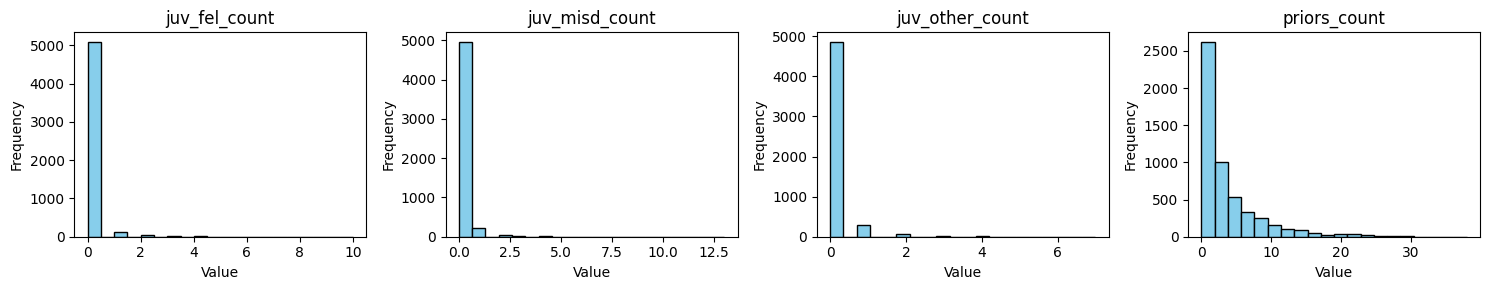

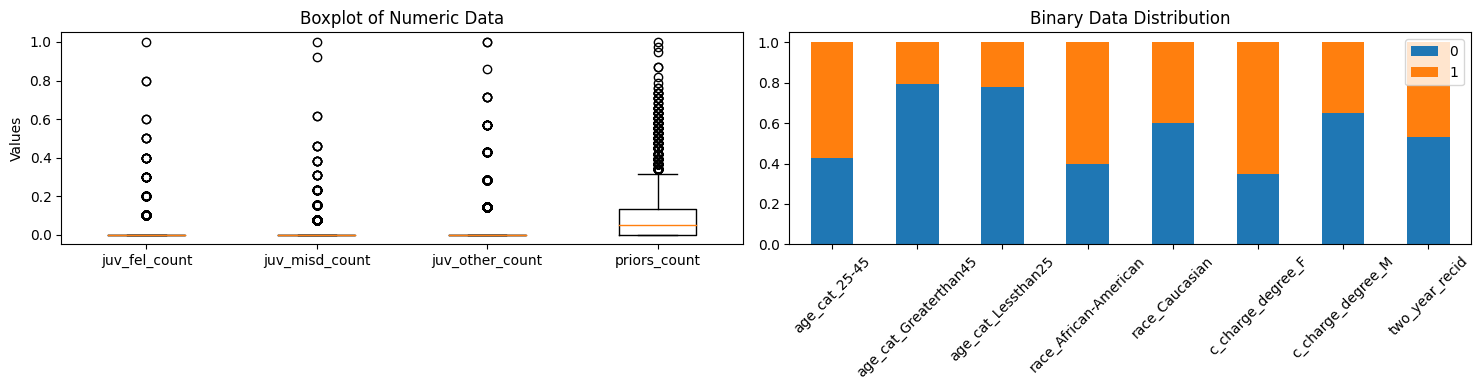

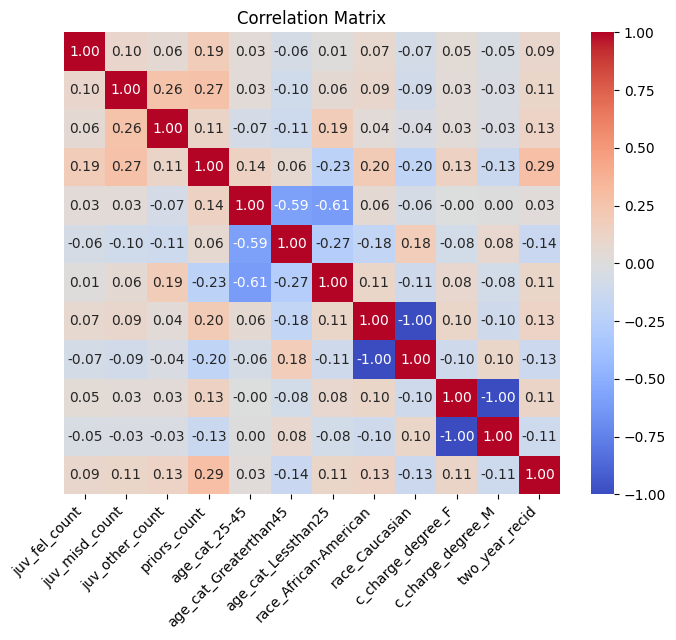

In [ ]:
# Call the initial_plot function to visualize data1
initial_plot(data1)

## Model Architectures

<img src="https://drive.google.com/uc?id=1TrkjaAD29M0HX5bR_vIFIG_4dbZXWE-E" width="500">

The SDAT architecture, adapted from [2], consists of four main components:
1. **Encoder**: Consists of 2 Fully-Connected Layers, which take in the dataset with a specific input size to generate the mean ($\mu$) and standard deviation ($\sigma$) of the latent space
2. **Reparameterize**: This layer is designed to create a latent space (${z}$) from the mean ($\mu$), standard deviation ($\sigma$), and noise ($\epsilon$) sampled from a normal distribution
3. **Decoder**: Consists of 2 Fully-Connected Layers taking in the latent space to generate an output ($\hat{x}$) that is similar to the input (${x}$)
4. **Classifier**: Comprises 2 Fully-Connected Layers. It takes in the latent space from the original data $z_x = \mu_x + \sigma_x$ and the generated data $z_{\hat{x}} = \mu_{\hat{x}} + \epsilon \cdot \sigma_{\hat{x}}$. The classifier then predicts the labels of the data ($\hat{y}_x$, $\hat{y}_{\hat{x}}$)

*Note: The decoder is actually separated into three sub-decoders for each type of feature, and the results will be combined afterward to generate new data.*

In [ ]:
class SDAT(nn.Module):
    def __init__(self, input_size, num_class, hidden_size=128, latent_size=32, hidden_classifer_size=8, type_indices=None):
        super(SDAT, self).__init__()
        self.input_size = input_size
        self.latent_size = latent_size
        self.type_indices = type_indices

        # Encoder layers with Batch Normalization
        self.enc1 = nn.Linear(input_size, hidden_size)
        self.enc_bn1 = nn.BatchNorm1d(hidden_size)
        self.enc_mu = nn.Linear(hidden_size, latent_size)
        self.enc_bn_mu = nn.BatchNorm1d(latent_size)
        self.enc_logvar = nn.Linear(hidden_size, latent_size)
        self.enc_bn_logvar = nn.BatchNorm1d(latent_size)

        # Decoder layers
        self.dec1 = nn.Linear(latent_size, hidden_size)
        self.dec2 = nn.Linear(hidden_size, input_size)

        if type_indices is not None:
            # Binary features
            self.dec11 = nn.Linear(latent_size, hidden_size)
            self.dec21 = nn.Linear(hidden_size, len(type_indices[0]))

            # Categorical features
            self.dec12 = nn.Linear(latent_size, hidden_size)
            self.dec22 = nn.Linear(hidden_size, len(type_indices[1]))

            # Numeric features
            self.dec13 = nn.Linear(latent_size, hidden_size)
            self.dec23 = nn.Linear(hidden_size, len(type_indices[2]))

        # Classifier layers
        self.fc1 = nn.Linear(latent_size, hidden_classifer_size)
        self.fc2 = nn.Linear(hidden_classifer_size, num_class)

    def encode(self, x):
        x = F.relu(self.enc_bn1(self.enc1(x)))
        mu = self.enc_mu(x)
        logvar = self.enc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar, hat=False):
        std = torch.exp(0.5 * logvar)
        if hat:
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu + std

    def decode(self, z):
        if self.type_indices is None:
            z = F.relu(self.dec1(z))
            return F.relu(self.dec2(z))
        else:
            x_binary = F.relu(self.dec11(z))
            x_binary = self.dec21(x_binary)

            x_categ = F.relu(self.dec12(z))
            x_categ = self.dec22(x_categ)

            x_numeric = F.relu(self.dec13(z))
            x_numeric = self.dec23(x_numeric)

            x_recon = torch.zeros((z.shape[0], self.input_size)).to(device)
            if len(self.type_indices[0]) > 0:
                x_recon[:, self.type_indices[0]] = x_binary
            if len(self.type_indices[1]) > 0:
                x_recon[:, self.type_indices[1]] = x_categ
            if len(self.type_indices[2]) > 0:
                x_recon[:, self.type_indices[2]] = x_numeric
            return x_recon

    def classifier(self, z):
        y_pred = F.relu(self.fc1(z))
        return torch.sigmoid(self.fc2(y_pred))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar, False)
        y_pred_z = self.classifier(z)
        z_hat = self.reparameterize(mu, logvar, True)
        x_hat = self.decode(z_hat)
        mu_x_hat, logvar_x_hat = self.encode(x_hat)
        y_pred_z_recon = self.classifier(self.reparameterize(mu_x_hat, logvar_x_hat, False))
        return x_hat, mu, logvar, y_pred_z, y_pred_z_recon

Here, we define our loss function, which consists of two main losses: augmented loss $L_{\text{aug}}$ and semi-supervised learning loss $L_{\text{ssl}}$. The details are as follows:
- **Augmented Loss:**: $L_{\text{aug}} = L_{\text{recon}} + L_{\text{KL}}$
  - *Reconstruction Loss:* Binary Cross Entropy for binary features, Mean Square Error for others.
  - *KL Divergence:* ${\small \alpha \text{KL}(\mathbf{q}(\mathbf{z}|\mathbf{x}) || \mathbf{p}(\mathbf{z})) + \beta \text{KL}(\mathbf{q}(\mathbf{z}|\mathbf{x}) || \mathbf{p}(\tilde{\mathbf{z}}|\mathbf{x}))}$ = ${\small \alpha \left( \sigma_{ij}^2 + \mu_{ij}^2 - \log(\sigma_{ij}^2) \right) + \beta \frac{\mu_{ij}^2}{\sigma_{ij}^2}}$
- **Semi-Supervised Learning Loss:** $L_{\text{ssl}} = L_{\text{ce}} + \lambda \cdot L_{\text{ssl_kl}}$

  - *Cross Entropy Loss:* Compare original labels (${y_x}$) and predicted labels ($\hat{y}_x$)
  - *KL divergence:* Compare predicted labels of the original dataset ($\hat{y}_x$) and the generated dataset ($\hat{y}_{\hat{x}}$)





In [ ]:
def loss_function(x_hat, mu, logvar, y_pred_z, y_pred_z_recon, X, y, type_indice, alpha=0.1, beta=0.1, lamb=0.1):
    def kl_divergence_with_stop_gradient(y_pred_inputs, y_pred_x_recon):
        y_pred_inputs = y_pred_inputs.detach()
        kl_div = F.kl_div(y_pred_inputs.log_softmax(dim=1), y_pred_x_recon.softmax(dim=1), reduction='batchmean')
        return kl_div

    type_indice = type_indice.copy()
    for index, indices in enumerate(type_indice):
        if len(indices) == 1:
            type_indice[index] = indices[0]
        elif len(indices) == 0:
            type_indice[index] = -1
        else:
            type_indice[index] = indices

    # Augmentation Loss
    kld = 0.5 * torch.sum(alpha*(logvar.exp()+mu.pow(2)-logvar)+beta*mu.pow(2)/logvar.exp(), dim=1)
    kld = torch.mean(kld) / x_hat.shape[1]

    # Reconstruction Loss
    recon_binary, recon_categ, recon_numeric = 0,0,0
    if type_indice[0]!=-1:
        recon_binary = F.binary_cross_entropy_with_logits(x_hat[:, type_indice[0]], X[:, type_indice[0]])
    if type_indice[1]!=-1:
        recon_categ = F.mse_loss(x_hat[:, type_indice[1]], X[:, type_indice[1]])
    if type_indice[2]!=-1:
        recon_numeric = F.mse_loss(x_hat[:, type_indice[2]], X[:, type_indice[2]])
    recon_total = (recon_binary + recon_categ + recon_numeric)/x_hat.shape[1]

    # Classification Loss
    loss_ce = F.cross_entropy(y_pred_z, y.long())
    loss_ssl_kl = kl_divergence_with_stop_gradient(y_pred_z, y_pred_z_recon)
    loss_ssl = loss_ce + lamb * loss_ssl_kl

    # Combined Loss
    loss = kld + recon_total + loss_ssl
    return loss, [kld, recon_total, loss_ce, loss_ssl_kl]

In [ ]:
# Define a function to prepare data and create DataLoader
def prepare_data(dataframe, batch_size=32, shuffle=False, include_labels=False):
    if not include_labels:
        features = torch.tensor(dataframe.iloc[:, :-1].values, dtype=torch.float32)
    else:
        features = torch.tensor(dataframe.values, dtype=torch.float32)
    labels = torch.tensor(dataframe.iloc[:, -1].values, dtype=torch.long)
    dataset = TensorDataset(features.to(device), labels.to(device))
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return data_loader

In [ ]:
def train_sdat(data, batch_size=32, epochs=10, alpha=0.1, beta=0.1, lamb=0.1, train_size=None):
    # Get DataLoader for each set
    if train_size is None:
        train_loader = prepare_data(data.train_set, batch_size=batch_size, shuffle=True, include_labels=True)
    else:
        train_loader = prepare_data(data.train_set[:train_size], batch_size=batch_size, shuffle=True, include_labels=False)
    valid_loader = prepare_data(data.valid_set, batch_size=len(data.valid_set), shuffle=False, include_labels=True)

    num_features = data.train_set.shape[1]

    # Initialize SDAT model and optimizer
    sdat = SDAT(num_features, num_class=2, type_indices=data.type_indices).to(device)
    optimizer = optim.Adam(sdat.parameters(), lr=0.001)

    # Lists to store losses for plotting
    total_loss_list = []
    loss_kl_list = []
    loss_recon_list = []
    loss_ce_list = []
    loss_ssl_kl_list = []

    accuracy_list = []
    accuracy_rec_list = []

    for epoch in tqdm(range(epochs)):
        total_loss = 0.0
        total_loss_kl = 0.0
        total_loss_recon = 0.0
        total_loss_ce = 0.0
        total_loss_ssl_kl = 0.0

        for X, y in train_loader:
            optimizer.zero_grad()

            x_hat, mu, logvar, y_pred_z, y_pred_z_recon = sdat(X)

            loss, losses = loss_function(x_hat, mu, logvar, y_pred_z, y_pred_z_recon, X, y, data.type_indices, alpha, beta, lamb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(sdat.parameters(), max_norm=5.0)

            optimizer.step()

            # Accumulate losses
            total_loss += loss.item()
            total_loss_kl += losses[0].item()
            total_loss_recon += losses[1].item()
            total_loss_ce += losses[2].item()
            total_loss_ssl_kl += losses[3].item()

        # Calculate average losses for the epoch
        avg_loss = total_loss / len(train_loader)
        avg_loss_kl = total_loss_kl / len(train_loader)
        avg_loss_recon = total_loss_recon / len(train_loader)
        avg_loss_ce = total_loss_ce / len(train_loader)
        avg_loss_ssl_kl = total_loss_ssl_kl / len(train_loader)

        # Append losses to the lists
        total_loss_list.append(avg_loss)
        loss_kl_list.append(avg_loss_kl)
        loss_recon_list.append(avg_loss_recon)
        loss_ce_list.append(avg_loss_ce)
        loss_ssl_kl_list.append(avg_loss_ssl_kl)

        # Evaluate the model
        with torch.no_grad():
            sdat.eval()
            x_valid, y_valid = next(iter(valid_loader))
            x_recon, _, _, y_pred_z, y_pred_z_recon = sdat(x_valid)

            _, z_predicted = torch.max(y_pred_z, 1)
            _, z_recon_predicted = torch.max(y_pred_z_recon, 1)
            accuracy = (z_predicted == y_valid).sum().item() / len(y_valid)
            accuracy_rec = (z_recon_predicted == y_valid).sum().item() / len(y_valid)
            accuracy_list.append(accuracy)
            accuracy_rec_list.append(accuracy_rec)

        # Print progress and accuracy
        if (epoch / epochs * 100) % 20 == 0 or epoch == epochs - 1:
            print(f'Epoch {epoch + 1}/{epochs}, Average Loss: {avg_loss:.3f}')
            print(f'Accuracy on valid set - original: {accuracy:.3f}, generated: {accuracy_rec:.3f}')

    # Plotting the losses and accuracies
    plt.figure(figsize=(12, 6))

    # Plotting the losses
    plt.subplot(1, 2, 1)
    plt.plot(total_loss_list, label='Total Loss')
    plt.plot(loss_kl_list, label='KL Loss')
    plt.plot(loss_recon_list, label='Recon Loss')
    plt.plot(loss_ce_list, label='SSL CE Loss')
    plt.plot(loss_ssl_kl_list, label='SSL KL Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting the accuracies
    plt.subplot(1, 2, 2)
    plt.plot(accuracy_list, label='Accuracy (Orginal Dataset, Valid)')
    plt.plot(accuracy_rec_list, label='Accuracy (Generated Dataset, Valid)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return sdat


After tuning our hyperparameters, we arrive at the following:

  1%|          | 1/150 [00:03<09:07,  3.67s/it]

Epoch 1/150, Average Loss: 1.874
Accuracy on valid set - original: 0.624, generated: 0.538


 21%|██▏       | 32/150 [00:08<00:17,  6.75it/s]

Epoch 31/150, Average Loss: 0.640
Accuracy on valid set - original: 1.000, generated: 0.910


 41%|████▏     | 62/150 [00:12<00:15,  5.68it/s]

Epoch 61/150, Average Loss: 0.624
Accuracy on valid set - original: 1.000, generated: 0.880


 61%|██████▏   | 92/150 [00:18<00:10,  5.75it/s]

Epoch 91/150, Average Loss: 0.609
Accuracy on valid set - original: 1.000, generated: 0.902


 81%|████████▏ | 122/150 [00:22<00:03,  7.20it/s]

Epoch 121/150, Average Loss: 0.608
Accuracy on valid set - original: 1.000, generated: 0.883


100%|██████████| 150/150 [00:26<00:00,  5.66it/s]


Epoch 150/150, Average Loss: 0.597
Accuracy on valid set - original: 1.000, generated: 0.876


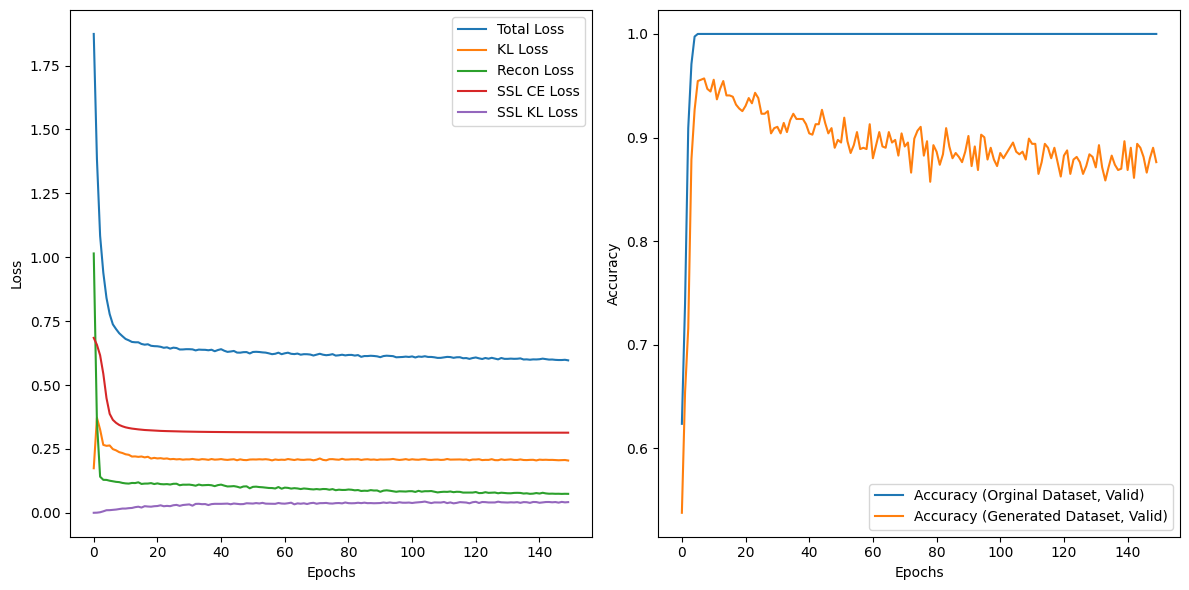

In [ ]:
# Train the SDAT model on the provided dataset (data1)
sdat1 = train_sdat(data1, batch_size=256, epochs=150, alpha=0.1, beta=0.1, lamb=0.1)

Here, the accuracy plot of the validation set for the original data (blue line) should reach 1.0 as we include label data in the encoder, and the model should find a way to extract that data from the latent space for prediction. However, the accuracy from the generated data is lower than 1.0 because some noise is added to the latent space. Also, Comparing accuracy with original labels may not be an accurate measure, as sometimes the generated data does not necessarily have the same labels as the original data, but it can show that the generated data is **not the same** as the original.

# Evaluation

In our evaluation phase, we perform a series of statistical tests on the generated data and compare with the original data.


*   **Visual Comparison**: plotting the each feature's original distribution and generated distribution side by side. We want similar plots.
*   **Wasserstein Distance**: least amount of effort needed to turn one set of probabilities into another. Lower is better.
*   **Kolmogorov Smirnov**: measures the maximum vertical distance between the two datasets' cumulative distribution functions. Lower is better.
*   **Correlation Matrix**: the correlation between each feature in the original vs the generated data. We want similar numbers in the correlation matrices.
*   **Pearson Correlation Coefficient**: quantifies the degree and direction of a linear relationship between two continuous variables. We want this close to 1.0
*   **PCA**: identifies the directions along which the distributions vary the most, assuming linear relationships. We want overlapping clusters.
*   **t-SNE**: maps each distribution's data points onto lower-dimensional representations using a non-linear transformation. We aim for the resulting clusters to overlap.
*   **Machine Learning Model**: Train two models (of the same architecture) on each dataset (original and generated). And evaluate on a small test dataset (separated from the original dataset in the beginning). We want similar accuracies.

The functions related to the results will be defined first, followed by the presentation of the results.

## Evaluation Function

In this step, we will initially generate data from a random normal distribution in the latent space. The data generated using this method will not be traceable back to any original data, unlike when generated by inputting the original data into the encoder, which tends to produce most features with the same values. Afterward, various post-processing steps are applied, such as rounding numbers for data that are originally integers, clipping the range of numeric data to their original maximum and minimum values, and decoding some data back to word categories.

In [ ]:
def generate_data(data, model, num_samples=500, output_name='output.csv'):
    """
    Generate synthetic data samples using the trained SDAT model.
    """

    # Set the model to evaluation mode
    model.eval()

    # Generate synthetic samples from random latent space points
    with torch.no_grad():
        latent_samples = torch.randn(num_samples, model.latent_size).to(device)
        x_recon = model.decode(latent_samples)
        x_recon = x_recon.cpu().numpy()

    # Create a DataFrame with generated data
    df_gen = pd.DataFrame(x_recon, columns=data.data.columns)

    # Adjust binary data to 0 or 1
    df_gen.iloc[:, data.type_indices[0]] = np.where(df_gen.iloc[:, data.type_indices[0]] > 0, 1, 0)

    # Convert data types to match the original dataset
    for col in data.binary_data:
        df_gen[col] = df_gen[col].astype(data.data[col].dtype)

    for col in data.categorical_data:
        df_gen[col] = df_gen[col].round().astype(data.data[col].dtype)

    for col in data.numeric_data:
        if pd.api.types.is_integer_dtype(data.data[col]):
            df_gen[col] = df_gen[col].round().astype(data.data[col].dtype)
        else:
            df_gen[col] = df_gen[col].astype(data.data[col].dtype)

    # Clip values to be within the original range
    for col in data.data.columns:
        df_gen[col] = df_gen[col].clip(lower=data.data[col].min(), upper=data.data[col].max())

    # Create a DataFrame with decoded categorical variables
    df_decoded = df_gen.copy()

    # Inverse transform label-encoded columns
    for col in data.label_encoders:
        df_decoded[col] = data.label_encoders[col].inverse_transform(df_gen[col])

    # Save the generated data to a CSV file
    df_decoded.to_csv(output_name, index=True)

    return df_gen, df_decoded

In [ ]:
data1.generated_data, data1.reformat_data = generate_data(data1, sdat1, num_samples=len(data1.data), output_name='new_repeatoffense.csv')

First let's see some samples.

In [ ]:
# Display the first few rows of the original data from data1, excluding the 'id' column if present
data1.original_data.drop(['id'], axis=1, errors='ignore').head()

juv_fel_count  juv_misd_count  juv_other_count  priors_count  \
0              0               0                0             0   
1              0               0                1             4   
2              0               0                0            14   
3              0               0                0             0   
4              0               0                0             0   

   age_cat_25-45  age_cat_Greaterthan45  age_cat_Lessthan25  \
0              1                      0                   0   
1              0                      0                   1   
2              1                      0                   0   
3              1                      0                   0   
4              1                      0                   0   

   race_African-American  race_Caucasian  c_charge_degree_F  \
0                      1               0                  1   
1                      1               0                  1   
2                      0               1                  1   
3                      0               1                  0   
4                      0               1                  1   

   c_charge_degree_M  two_year_recid  
0                  0               1  
1                  0               1  
2                  0               1  
3                  1               0  
4                  0               0

In [ ]:
# Display the first few rows of the reformatted generated data in data1
data1.reformat_data.head()

juv_fel_count  juv_misd_count  juv_other_count  priors_count  \
0              0               0                0             4   
1              0               0                0             4   
2              0               0                0             1   
3              0               1                0             7   
4              0               0                0             7   

   age_cat_25-45  age_cat_Greaterthan45  age_cat_Lessthan25  \
0              1                      0                   0   
1              1                      0                   0   
2              0                      0                   0   
3              0                      0                   1   
4              0                      1                   0   

   race_African-American  race_Caucasian  c_charge_degree_F  \
0                      1               0                  0   
1                      0               1                  0   
2                      0               1                  0   
3                      1               0                  1   
4                      1               0                  1   

   c_charge_degree_M  two_year_recid  
0                  1               0  
1                  1               1  
2                  1               0  
3                  0               1  
4                  0               0

These data look very similar when judged individually, and it could be implied that they might come from the same dataset, even though they are different.

In [ ]:
def compare_distributions(original_df, generated_df, type_indices, num_bins=30):
    """
    Compare distributions of numerical features between the original and generated samples.

    Parameters:
    - original_df (pd.DataFrame): Original DataFrame
    - generated_df (pd.DataFrame): Generated DataFrame
    - type_indices (list): List containing indices of different feature types
    - num_bins (int): Number of bins for histograms

    Returns:
    - None
    """
    # Extract non-binary indices
    nonbinary_indices = sorted(type_indices[1] + type_indices[2])
    double_indices = [nonbinary_indices[i:i+2] for i in range(0, len(nonbinary_indices), 2)]

    # Check if the last index is single, append -1 to make it double
    if len(double_indices[-1]) == 1:
        double_indices[-1].append(-1)

    for col1, col2 in double_indices:
        # Create subplots for two pairs of distributions
        fig, axes = plt.subplots(1, 4, figsize=(16, 2))

        # Plot original distribution for feature col1
        combine_range = (min(original_df.iloc[:, col1].min(), generated_df.iloc[:, col1].min()),
                         max(original_df.iloc[:, col1].max(), generated_df.iloc[:, col1].max()))
        sns.histplot(original_df.iloc[:, col1], bins=np.linspace(combine_range[0], combine_range[1], num_bins),
                     color='blue', ax=axes[0])
        axes[0].set_title(f'Original Distribution')

        # Plot generated distribution for feature col1
        sns.histplot(generated_df.iloc[:, col1], bins=np.linspace(combine_range[0], combine_range[1], num_bins),
                     color='orange', ax=axes[1])
        axes[1].set_title(f'Generated Distribution')

        # Plot original distribution for feature col2
        combine_range = (min(original_df.iloc[:, col2].min(), generated_df.iloc[:, col2].min()),
                         max(original_df.iloc[:, col2].max(), generated_df.iloc[:, col2].max()))
        sns.histplot(original_df.iloc[:, col2], bins=np.linspace(combine_range[0], combine_range[1], num_bins),
                     color='blue', ax=axes[2])
        axes[2].set_title(f'Original Distribution')

        # Plot generated distribution for feature col2
        sns.histplot(generated_df.iloc[:, col2], bins=np.linspace(combine_range[0], combine_range[1], num_bins),
                     color='orange', ax=axes[3])
        axes[3].set_title(f'Generated Distribution')

        # Hide subplots for single-feature distribution (col2=-1)
        if col2 == -1:
            axes[2].set_visible(False)
            axes[3].set_visible(False)

        # Hide y-axis ticks for all subplots
        for i in range(4):
            axes[i].set_yticks([])

        # Show the plots
        plt.show()

    # Analyze and compare distributions of binary features
    percentage_df1 = original_df.iloc[:, type_indices[0]].apply(lambda x: x.value_counts(normalize=True)).transpose()
    percentage_df2 = generated_df.iloc[:, type_indices[0]].apply(lambda x: x.value_counts(normalize=True)).transpose()

    # Create subplots for bar charts
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    # Plot stacked bar chart for the original distribution
    percentage_df1.plot.bar(stacked=True, ax=axes[0])
    axes[0].set_title('Original Distribution')

    # Plot stacked bar chart for the generated distribution
    percentage_df2.plot.bar(stacked=True, ax=axes[1])
    axes[1].set_title('Generated Distribution')

    # Rotate x-axis labels if there are more than 5 categories
    if len(type_indices[0]) > 5:
        axes[0].tick_params(axis='x', rotation=45)
        axes[1].tick_params(axis='x', rotation=45)

    # Adjust layout for better visualization
    plt.tight_layout()

    # Show the plots
    plt.show()


In [ ]:
def wdistance_difference(original_df, generated_df):
    """
    Evaluate Wasserstein distance for continuous numerical features between the original and generated samples.

    Parameters:
    - original_df (pd.DataFrame): DataFrame containing original data.
    - generated_df (pd.DataFrame): DataFrame containing generated data.

    Returns:
    - None
    """
    # Generate feature types based on the number of unique values
    feature_types = ['binary' if count == 2 else 'numerical' for count in original_df.nunique()]
    numerical_features = [col for i, col in enumerate(original_df.columns) if feature_types[i] == 'numerical']

    # Calculate Wasserstein distances for numerical features
    w_distances = {}
    for feature in numerical_features:
        w_distances[feature] = wasserstein_distance(original_df[feature], generated_df[feature])

    # Extract feature names and their corresponding Wasserstein distances
    features = list(w_distances.keys())
    wasserstein_values = [w_distances[feature] for feature in features]

    # Create a bar plot
    plt.figure(figsize=(10, 4))
    plt.bar(features, wasserstein_values, color='skyblue')

    # Add Wasserstein distance values on top of the bars
    for i in range(len(features)):
        plt.text(i, wasserstein_values[i], f"{wasserstein_values[i]:.2f}", ha='center', va='bottom')

    plt.ylabel('Wasserstein Distance')
    plt.title('Wasserstein Distances for Numerical Features')
    plt.tick_params(axis='x', rotation=45)
    plt.show()

In [ ]:
def compare_corr(df, df_gen):
    """
    Compare correlation matrices between the original and generated datasets.

    Parameters:
    - df (pd.DataFrame): Original DataFrame
    - df_gen (pd.DataFrame): Generated DataFrame

    Returns:
    - None
    """
    # Original Data: Calculate the correlation matrix
    correlation_original = df.corr()

    # Generated Data: Calculate the correlation matrix
    correlation_generated = df_gen.corr()

    # Visualize the original and generated correlation matrices side by side
    plt.figure(figsize=(12, 6))

    # Original Correlation Matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(correlation_original, cmap='coolwarm', annot=True, fmt=".2f", xticklabels=True, yticklabels=False)
    plt.title('Original Correlation Matrix')

    # Generated Correlation Matrix
    plt.subplot(1, 2, 2)
    sns.heatmap(correlation_generated, cmap='coolwarm', annot=True, fmt=".2f", xticklabels=True, yticklabels=False)
    plt.title('Generated Correlation Matrix')

    # Adjust layout for better visualization
    plt.tight_layout()

    # Show the plots
    plt.show()

    # Flatten the correlation matrices for correlation coefficient calculation
    flat_original = correlation_original.values.flatten()
    flat_generated = correlation_generated.values.flatten()

    # Compute Pearson correlation coefficient
    correlation_coefficient = np.corrcoef(flat_original, flat_generated)[0, 1]
    print(f"Pearson Correlation Coefficient: {correlation_coefficient:.2f}")


In [ ]:
def calculate_ks_statistics(original_data, generated_data, features):
    """
    Calculate Kolmogorov-Smirnov (KS) statistics for specified features between original and generated data.

    Parameters:
    - original_data (pd.DataFrame): The original DataFrame.
    - generated_data (pd.DataFrame): The DataFrame containing generated samples.
    - features (list): List of feature names to evaluate.

    Returns:
    - dict: Dictionary containing KS statistics for each feature.
    """
    ks_statistics = {}

    # Iterate through each specified feature
    for feature in features:
        original_feature_values = original_data[feature].values
        generated_feature_values = generated_data[feature].values

        # Calculate KS statistic and p-value using the ks_2samp test
        statistic, p_value = ks_2samp(original_feature_values, generated_feature_values)

        # Store the results in the ks_statistics dictionary
        ks_statistics[feature] = {'KS Statistic': statistic, 'P-Value': p_value}

    return ks_statistics


def plot_ks_statistics(data):
    """
    Plot KS statistics for numeric and categorical features.

    Parameters:
    - data (DataObject): An object containing original and generated data, along with feature categories.

    Returns:
    - None: Generates a bar plot of KS statistics.
    """
    # Combine numeric and categorical features for evaluation
    feature_types = ['binary' if count == 2 else 'numerical' for count in data.data.nunique()]
    features_to_evaluate = [col for i, col in enumerate(data.data.columns) if feature_types[i] == 'numerical']

    # Calculate KS statistics
    ks_stats = calculate_ks_statistics(data.data, data.generated_data, features_to_evaluate)

    # Extract feature names and their corresponding KS statistics
    features = list(ks_stats.keys())
    ks_values = [ks_stats[feature]['KS Statistic'] for feature in features]

    # Create a bar plot
    plt.figure(figsize=(10, 4))
    plt.bar(features, ks_values, color='skyblue')

    # Add the KS statistic values on top of the bars
    for i in range(len(features)):
        plt.text(i, ks_values[i], f"{ks_values[i]:.2f}", ha='center', va='bottom')

    plt.ylabel('KS Statistic')
    plt.title('Kolmogorov-Smirnov Statistics for Features')
    plt.tick_params(axis='x', rotation=45)
    plt.show()

In [ ]:
def plot_pca_tsne_comparison(original_df, generated_samples, title='PCA and t-SNE Comparison'):
    """
    Plots a PCA and t-SNE comparison between the original data and generated data.

    Parameters:
    - original_df (pd.DataFrame): The original DataFrame.
    - generated_samples (pd.DataFrame): The DataFrame containing generated samples.
    - title (str): The title of the plot.

    Returns:
    - None: The function generates a plot.
    """

    # Fit PCA on the standardized original data and transform both datasets
    pca = PCA(n_components=2)
    pca.fit(original_df)
    original_pca = pca.transform(original_df)
    generated_pca = pca.transform(generated_samples)

    # Fit t-SNE on the combined standardized data
    tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
    combined_standardized_data = np.vstack((original_df, generated_samples))
    tsne_results = tsne.fit_transform(combined_standardized_data)

    # Split t-SNE results
    original_tsne = tsne_results[:len(original_df), :]
    generated_tsne = tsne_results[len(original_df):, :]

    # Plotting PCA
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(original_pca[:, 0], original_pca[:, 1], alpha=0.3, color='blue', label='Original Data')
    plt.scatter(generated_pca[:, 0], generated_pca[:, 1], alpha=0.3, color='red', label='Generated Data')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.title('PCA of Original and Generated Data')

    # Plotting t-SNE
    plt.subplot(1, 2, 2)
    plt.scatter(original_tsne[:, 0], original_tsne[:, 1], alpha=0.3, color='blue', label='Original Data')
    plt.scatter(generated_tsne[:, 0], generated_tsne[:, 1], alpha=0.3, color='red', label='Generated Data')
    plt.xlabel('t-SNE Feature 1')
    plt.ylabel('t-SNE Feature 2')
    plt.legend()
    plt.title('t-SNE of Original and Generated Data')

    plt.suptitle(title)
    plt.show()


In [ ]:
# Define a custom accuracy function
def get_accuracy(model, data_loader):
    """
    Calculate accuracy of the model on a given DataLoader.

    Parameters:
    - model (nn.Module): PyTorch model
    - data_loader (DataLoader): DataLoader for the dataset

    Returns:
    - float: Accuracy
    """
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Model
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

def train_basic_nn(df, batch_size=512):
    """
    Train a basic neural network on the given DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame
    - batch_size (int): Batch size for training DataLoader

    Returns:
    - nn.Module: Trained neural network model
    """
    # Split the data
    train_df, test_df = train_test_split(df, test_size=0.3, random_state=20)
    valid_df, test_df = train_test_split(test_df, test_size=0.5, random_state=20)

    # Get DataLoader for each set
    train_loader = prepare_data(train_df, batch_size=batch_size, shuffle=True)
    valid_loader = prepare_data(valid_df, batch_size=batch_size, shuffle=False)
    test_loader = prepare_data(test_df, batch_size=batch_size, shuffle=False)

    # Hyperparameters
    input_size, hidden_size, output_size = train_df.shape[1] - 1, 64, 2  # Assuming 2 classes for classification
    num_epochs, learning_rate = 100, 0.001

    # Create the model
    model = SimpleNN(input_size, hidden_size, output_size).to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Lists to store training and validation accuracies
    train_accuracies, valid_accuracies = [], []

    # Training loop
    for epoch in tqdm(range(num_epochs)):
        model.train()
        for batch_features, batch_labels in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

        # Evaluation during training
        model.eval()
        valid_accuracy = get_accuracy(model, valid_loader)

        # Print and store training and validation metrics
        train_accuracies.append(get_accuracy(model, train_loader))
        valid_accuracies.append(valid_accuracy)

    # Plotting the accuracy curve
    plt.figure(figsize=(6, 3))
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Testing after training
    test_accuracy = get_accuracy(model, test_loader)
    print(f'Test Accuracy: {test_accuracy:.4f}')

    return model


In [ ]:
def get_test_accuracy(model1, model2, data, gen_df):
    """
    Calculate and display test accuracies for two classifiers on both original and generated testing sets.
    """
    # Get a test set from the new dataset, which is the same as when training model that it's never seen before
    _, test_df = train_test_split(gen_df, test_size=0.3, random_state=20)
    _, test_df = train_test_split(test_df, test_size=0.5, random_state=20)

    # Calculate test accuracies for both classifiers on original and generated testing sets
    test_accuracy1 = get_accuracy(model1, prepare_data(data.test_set, batch_size=32, shuffle=True))
    test_accuracy2 = get_accuracy(model2, prepare_data(data.test_set, batch_size=32, shuffle=True))
    test_accuracy3 = get_accuracy(model1, prepare_data(test_df, batch_size=32, shuffle=True))
    test_accuracy4 = get_accuracy(model2, prepare_data(test_df, batch_size=32, shuffle=True))

    # Create a DataFrame with formatted numbers
    data = {
        'Classifier Trained by Original Dataset': [test_accuracy1, test_accuracy3],
        'Classifier Trained by Generated Dataset': [test_accuracy2, test_accuracy4]
    }

    df = pd.DataFrame(data, index=['Original Testing Set Accuracy', 'Generated Testing Set Accuracy'])

    # Set the display format to three decimal places
    pd.set_option('display.float_format', '{:.3f}'.format)

    # Display the DataFrame
    display(df)

    # Reset the display format to default
    pd.reset_option('display.float_format')


## Result and Discussion

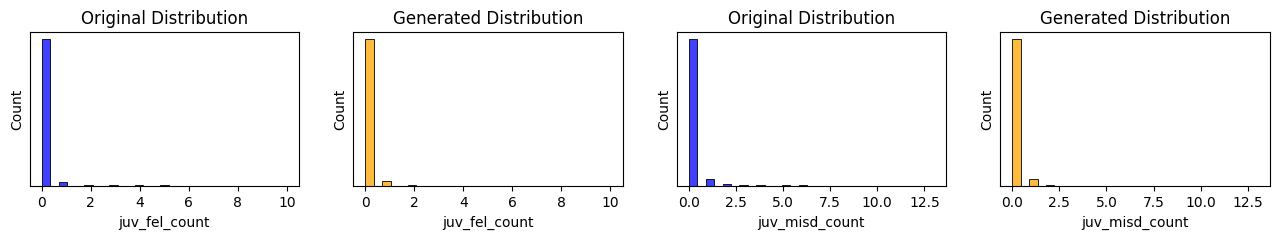

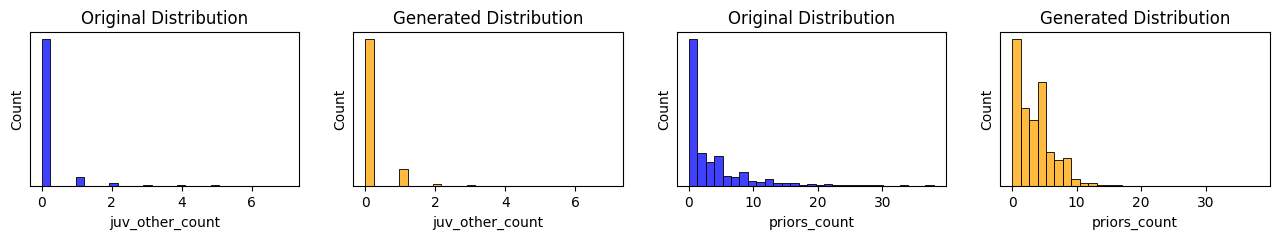

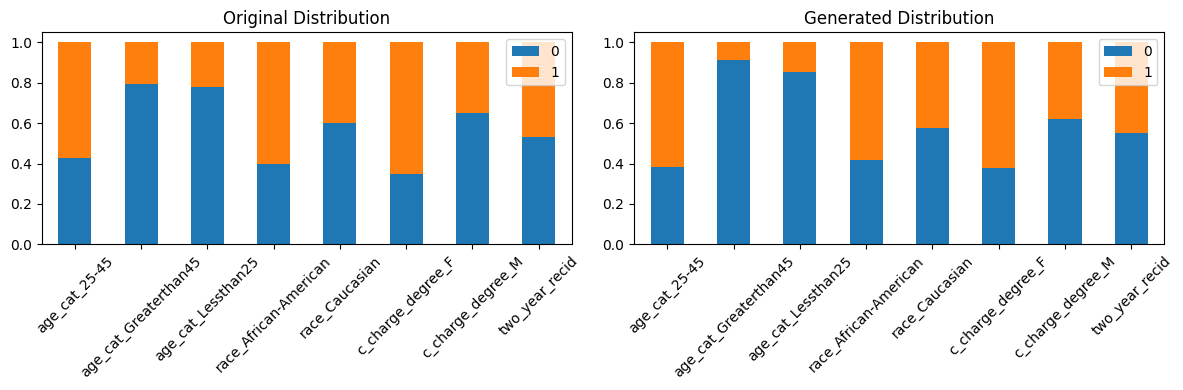

In [ ]:
compare_distributions(data1.data, data1.generated_data, data1.type_indices)

The generated distributions closely resembles the original dataset, with variations attributed to the normal distribution. This leads to a distribution shape around values with higher probabilities, reducing the presence of outliers.

For the binary data, most features appear to align closely, except for age_cat which seems to be acceptable but worse than others, possibly due to the subdivision of the original 'age' feature into three distinct features, making it harder to generate accurately.

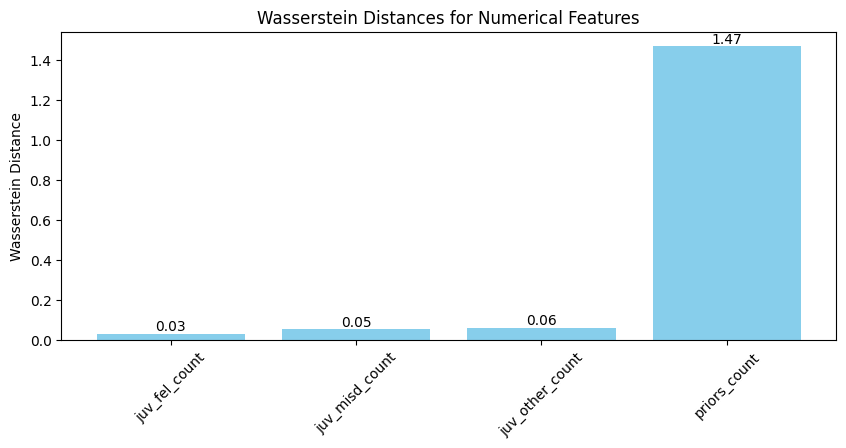

In [ ]:
wdistance_difference(data1.data, data1.generated_data)

We can observe that the Wasserstein distance between the two distributions is generally quite low, except for 'priors_count,' which is relatively high compared to the others. One partial reason for this discrepancy is the difference in the scale of the data, with 'priors_count' having a maximum value at least three times and a mean approximately 30 times that of the other features.

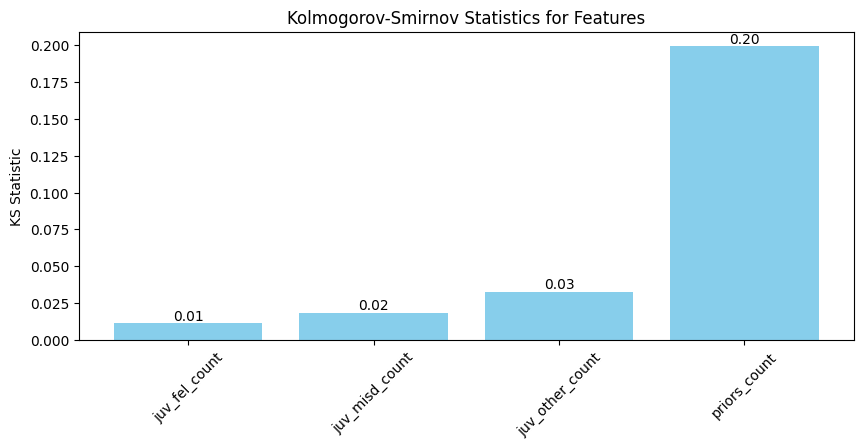

In [ ]:
plot_ks_statistics(data1)

We can observe that the values from the Kolmogorov-Smirnov test are consistently low, with, once again, 'priors_count' exhibiting a higher value compared to the others.

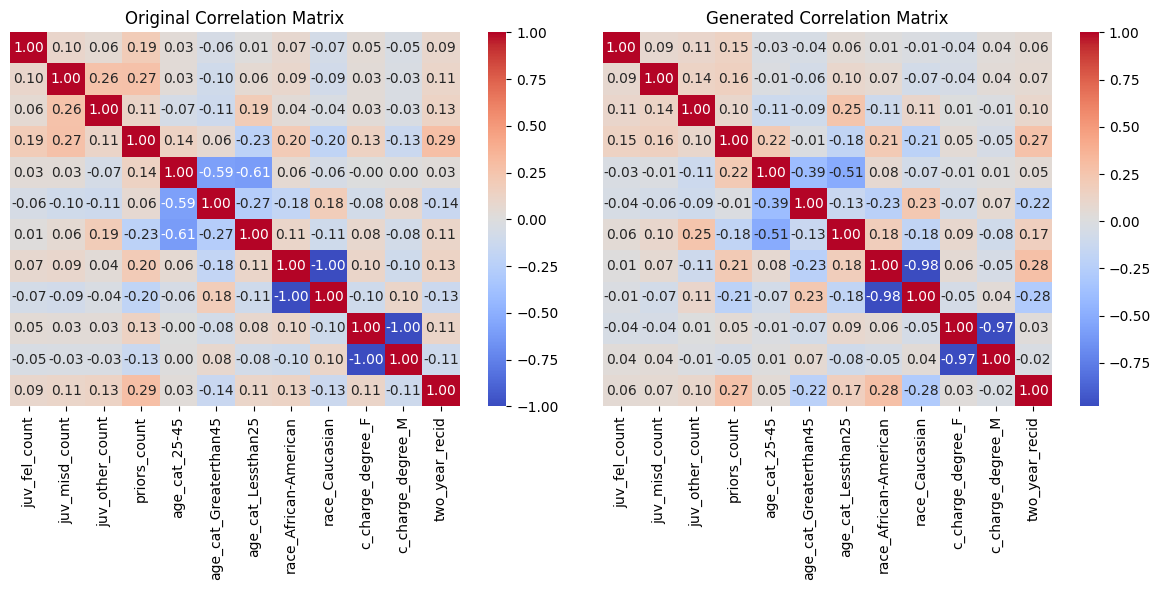

Pearson Correlation Coefficient: 0.98


In [ ]:
compare_corr(data1.data, data1.generated_data)

We can observe that the values in the original correlation matrix are quite similar to those in the generated correlation matrix. To be more precise, it can accurately capture features that are directly related, represented as -1 in the original matrix, and reproduces almost perfectly for bi-feature relationships, such as race and sex. However, it may perform less accurately for relationships involving more than two features, such as age in this case.

The Pearson Correlation Coefficient very close to 1 also shows that this generated data can maintain most relationships found in the original data.

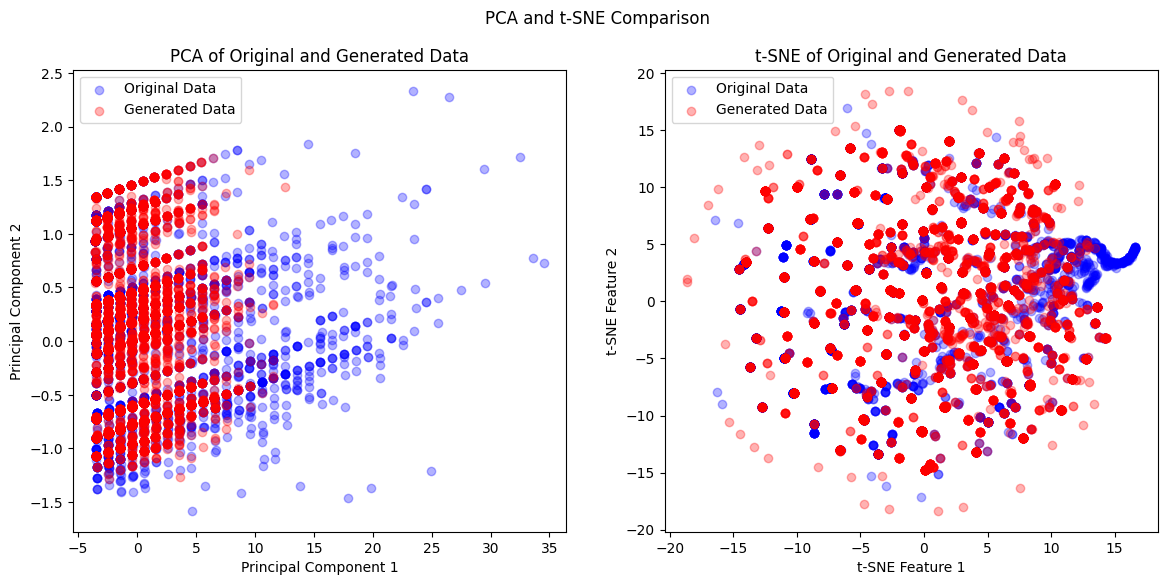

In [ ]:
# Use the function by passing the original data df, generated samples df
plot_pca_tsne_comparison(data1.data[:10000], data1.generated_data[:10000])

We can see that the generated (red) clusters closely resemble the original (blue) clusters. However, in PCA, it is evident that the spread or variance of the data decreases in the generated dataset, as observed by the generated clusters covering a smaller area compared to the original.

100%|██████████| 100/100 [00:09<00:00, 10.04it/s]


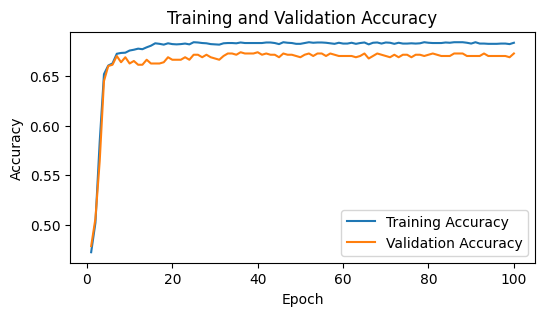

Test Accuracy: 0.6717


100%|██████████| 100/100 [00:09<00:00, 11.00it/s]


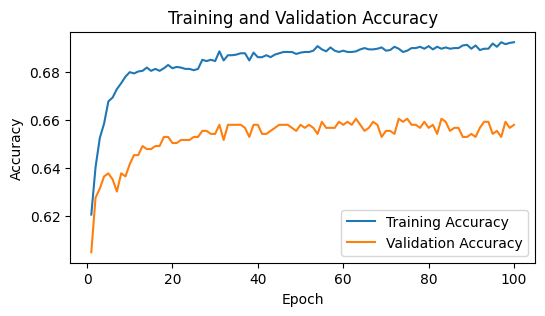

Test Accuracy: 0.6705


In [ ]:
model_nn1 = train_basic_nn(data1.data)
model_nn2 = train_basic_nn(data1.generated_data)

In [ ]:
get_test_accuracy(model_nn1, model_nn2, data1, data1.generated_data)

Classifier Trained by Original Dataset  \
Original Testing Set Accuracy                                    0.672   
Generated Testing Set Accuracy                                   0.641   

                                Classifier Trained by Generated Dataset  
Original Testing Set Accuracy                                     0.672  
Generated Testing Set Accuracy                                    0.670

We observe that, on a small test set, the two different models (one trained on the original data and one trained on the generated data) performed very similarly. This indicates that the our method of generating data can maintain enough statistical relationships between features, at least enough for basic machine learning models for a simple binary classification task.

# Examples on New Data

Here, we test our method on a new dataset: Breast cancer prediction and Income Prediction.

We chose these datasets because medical and financial data are generally very sensitive and are the key target areas of our project.

Here we generate the new data and evaluate on the exact same metrics as before:

*   **Visual Comparison**: plotting the each feature's original distribution and generated distribution side by side. We want similar plots.
*   **Wasserstein Distance**: least amount of effort needed to turn one set of probabilities into another. Lower is better.
*   **Kolmogorov Smirnov**: measures the maximum vertical distance between the two datasets' cumulative distribution functions. Lower is better.
*   **Correlation Matrix**: the correlation between each feature in the original vs the generated data. We want similar numbers in the correlation matrices.
*   **Pearson Correlation Coefficient**: quantifies the degree and direction of a linear relationship between two continuous variables. We want this close to 1.0
*   **PCA**: identifies the directions along which the distributions vary the most, assuming linear relationships. We want overlapping clusters.
*   **t-SNE**: maps each distribution's data points onto lower-dimensional representations using a non-linear transformation. We aim for the resulting clusters to overlap.
*   **Machine Learning Model**: Train two models (of the same architecture) on each dataset (original and generated). And evaluate on a small test dataset (separated from the original dataset in the beginning). We want similar accuracies.




In [ ]:
def get_new_data(filepath=None, url=None, output_name='output.csv', dropout=['id']):
    """
    Generate and analyze synthetic data using the SDAT framework.

    Parameters:
    - filepath (str): Local file path to the CSV file.
    - url (str): Shareable link of the CSV file on Google Drive.
    - output_name (str): Name for the output CSV file containing synthetic data.
    - dropout (list): List of columns to drop during data reading.

    Returns:
    - data (Dataset): An object containing information about the original and generated data
    """
    # Check if either filepath or url is provided
    if filepath is None and url is None:
        raise ValueError("Either 'filepath' or 'url' must be provided.")

    # Read the CSV file either from local filepath or Google Drive link
    if filepath is not None:
        data = read_csv(filepath=filepath, dropout=dropout)
    elif url is not None:
        data = read_csv(url=url, dropout=dropout)

    # Initial data exploration plot
    initial_plot(data)

    # Train SDAT model
    sdat = train_sdat(data, batch_size=256, epochs=150, alpha=0.1, beta=0.1, lamb=0.1)

    # Generate synthetic data and reformat original data
    data.generated_data, data.reformat_data = generate_data(data, sdat, num_samples=len(data.data), output_name=output_name)

    # Display a sample of the original and reformat data
    display(data.original_data.drop(['id'], axis=1, errors='ignore').head())
    display(data.reformat_data.head())

    # Compare distributions between original and generated data
    compare_distributions(data.data, data.generated_data, data.type_indices)
    wdistance_difference(data.data, data.generated_data)

    # Plot Kolmogorov-Smirnov (KS) statistics for features
    plot_ks_statistics(data)

    # Compare correlations between original and generated data
    compare_corr(data.data, data.generated_data)

    # Plot PCA and t-SNE comparison for the first 10,000 samples
    plot_pca_tsne_comparison(data.data[:10000], data.generated_data[:10000])

    # Train basic neural networks on the original and generated data
    model_nn1 = train_basic_nn(data.data)
    model_nn2 = train_basic_nn(data.generated_data)

    # Evaluate test accuracy on the generated data using the model trained on original data
    get_test_accuracy(model_nn1, model_nn2, data, data.generated_data)

    return data


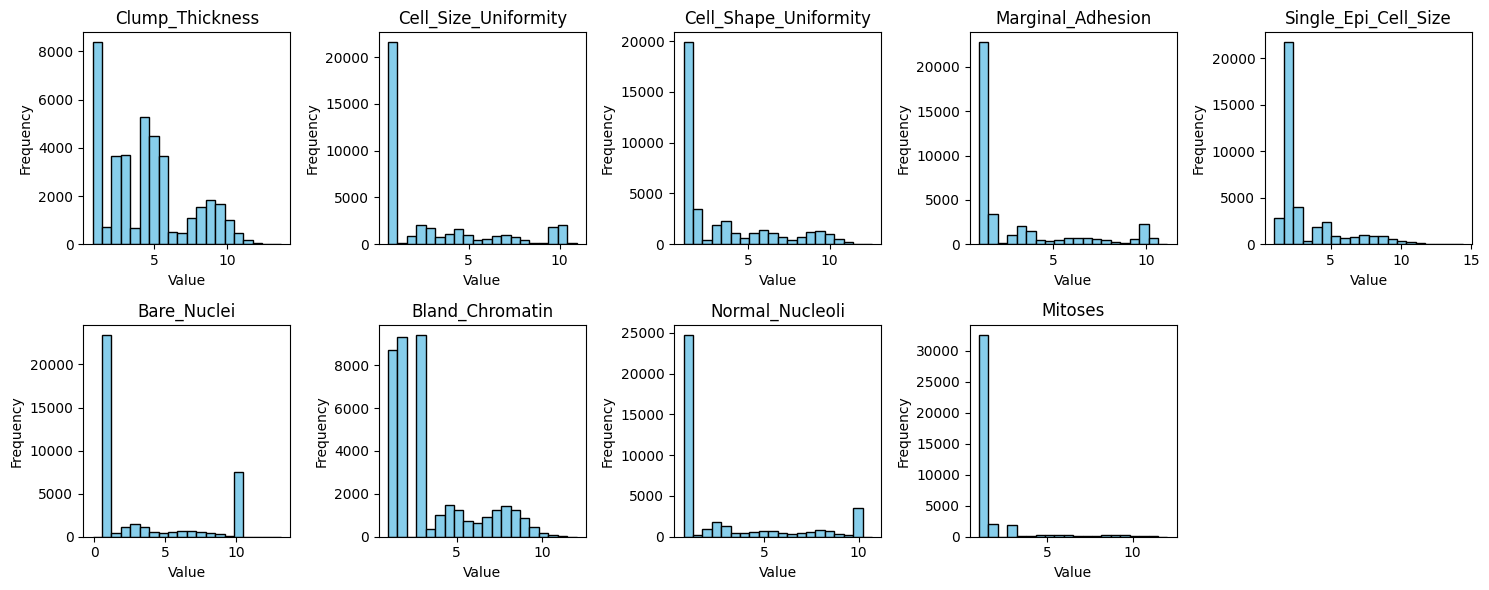

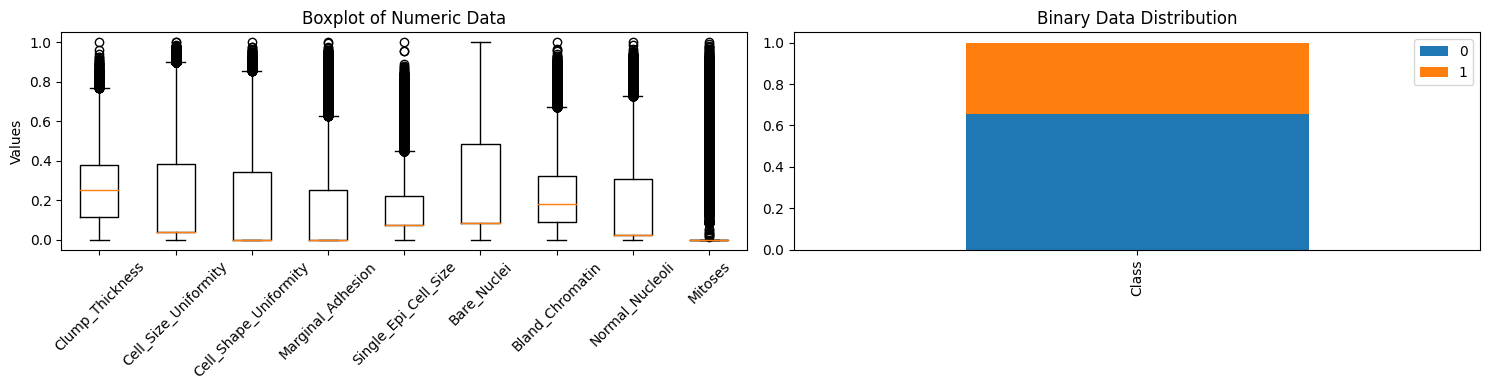

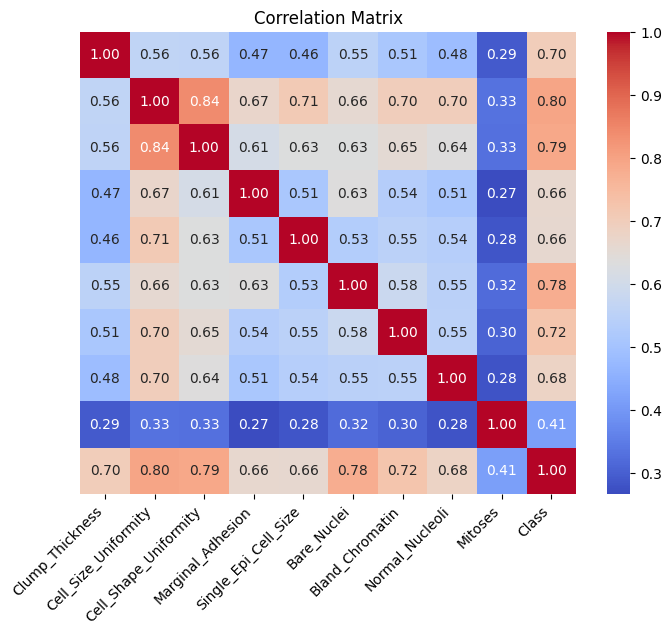

/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
  1%|          | 1/150 [00:00<02:22,  1.05it/s]

Epoch 1/150, Average Loss: 1.398
Accuracy on valid set - original: 0.981, generated: 0.960


 21%|██        | 31/150 [00:33<02:15,  1.14s/it]

Epoch 31/150, Average Loss: 0.720
Accuracy on valid set - original: 1.000, generated: 0.986


 41%|████      | 61/150 [01:04<01:28,  1.00it/s]

Epoch 61/150, Average Loss: 0.699
Accuracy on valid set - original: 1.000, generated: 0.990


 61%|██████    | 91/150 [01:34<00:57,  1.03it/s]

Epoch 91/150, Average Loss: 0.690
Accuracy on valid set - original: 1.000, generated: 0.993


 81%|████████  | 121/150 [02:06<00:33,  1.14s/it]

Epoch 121/150, Average Loss: 0.686
Accuracy on valid set - original: 1.000, generated: 0.993


100%|██████████| 150/150 [02:36<00:00,  1.04s/it]

Epoch 150/150, Average Loss: 0.685
Accuracy on valid set - original: 1.000, generated: 0.991


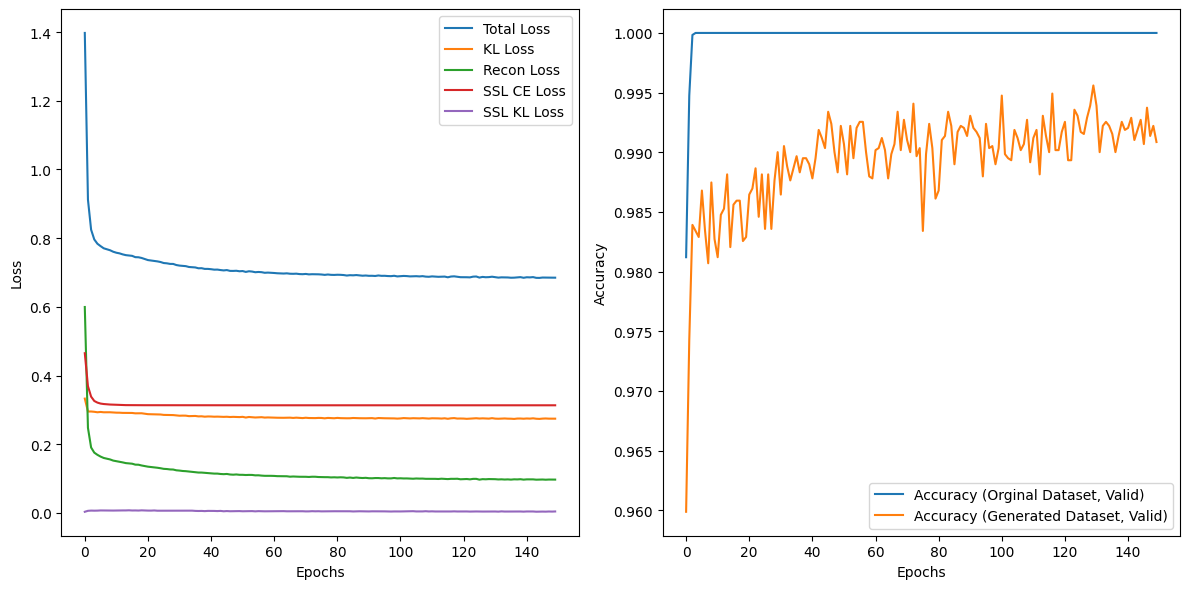

Clump_Thickness  Cell_Size_Uniformity  Cell_Shape_Uniformity  \
0         7.581819              9.745087               1.000000   
1         5.210921              8.169596               7.841875   
2         4.000000              4.594296               2.330380   
3         2.428871              1.000000               1.000000   
4         8.855971              2.697539               6.047068   

   Marginal_Adhesion  Single_Epi_Cell_Size  Bare_Nuclei  Bland_Chromatin  \
0           4.503410              7.039930         10.0         4.412282   
1           6.033275              4.269619         10.0         4.236312   
2           2.000000              3.000000          1.0        10.701823   
3           1.000000              4.099291          1.0         2.000000   
4           3.301891              3.000000          1.0         5.297592   

   Normal_Nucleoli   Mitoses      Class  
0        10.000000  5.055266  malignant  
1         4.845350  1.000000  malignant  
2         1.101305  1.000000     benign  
3         1.000000  1.000000     benign  
4         4.104791  3.115741  malignant

Clump_Thickness  Cell_Size_Uniformity  Cell_Shape_Uniformity  \
0         3.379726              6.319720               7.367049   
1         1.367662              2.500945               3.106199   
2        11.679756              6.610581               7.385446   
3         8.725392              8.796124               4.453030   
4         6.910299              1.177640               1.200110   

   Marginal_Adhesion  Single_Epi_Cell_Size  Bare_Nuclei  Bland_Chromatin  \
0           6.844478              6.348020     9.633006         4.945002   
1           2.309092              3.243720     1.189009         2.294845   
2           2.393413              7.188628     6.434070         6.612098   
3           7.917284              9.060058     7.283454         5.537799   
4           1.256070              1.961917     2.586970         1.680926   

   Normal_Nucleoli   Mitoses      Class  
0         5.133948  2.019184  malignant  
1         0.758343  1.056832     benign  
2         6.730819  2.454648  malignant  
3         4.706994  6.650554  malignant  
4         1.050349  1.030358     benign

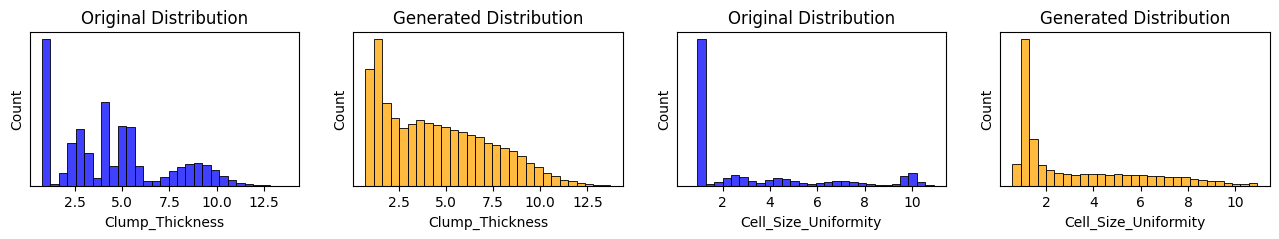

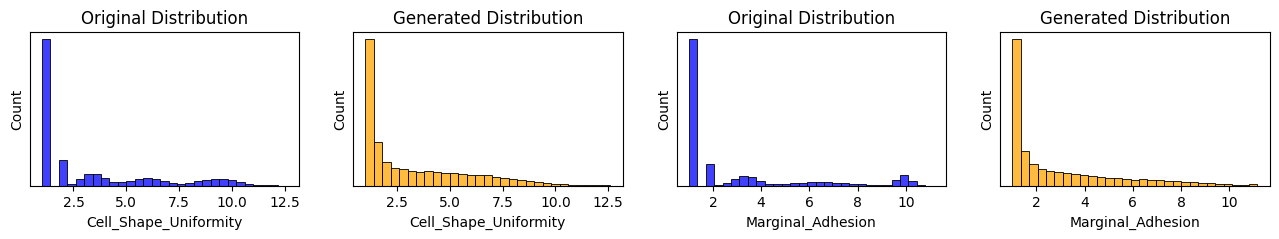

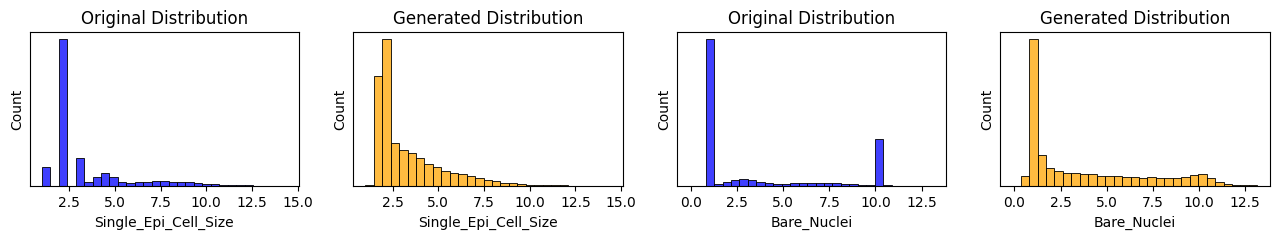

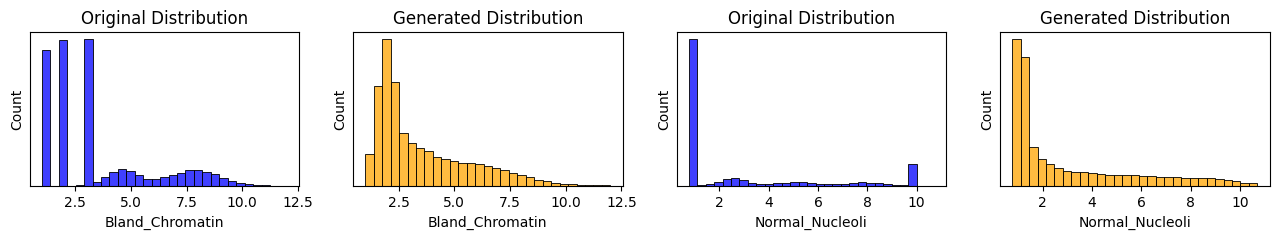

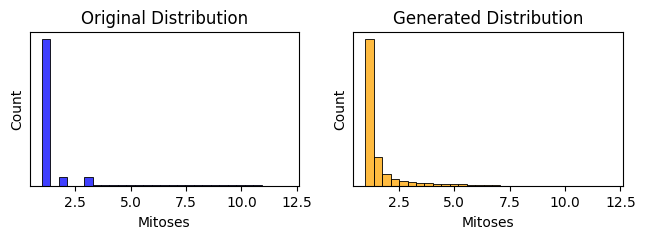

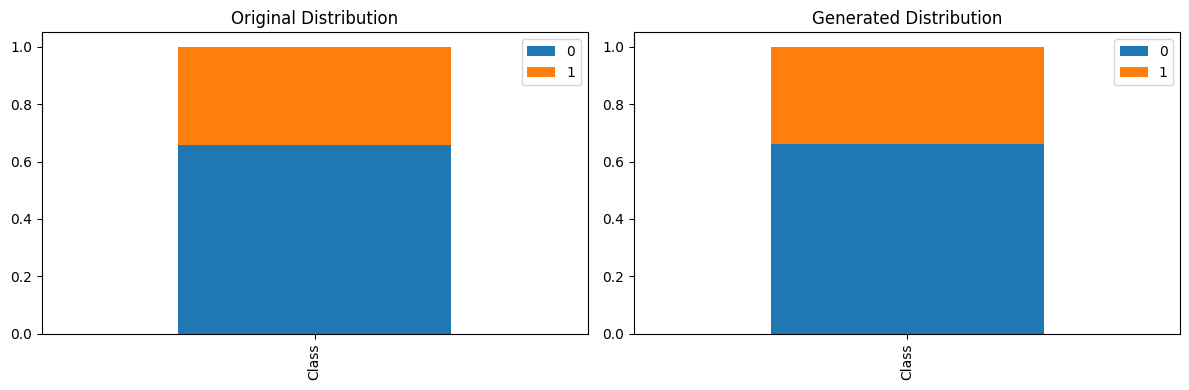

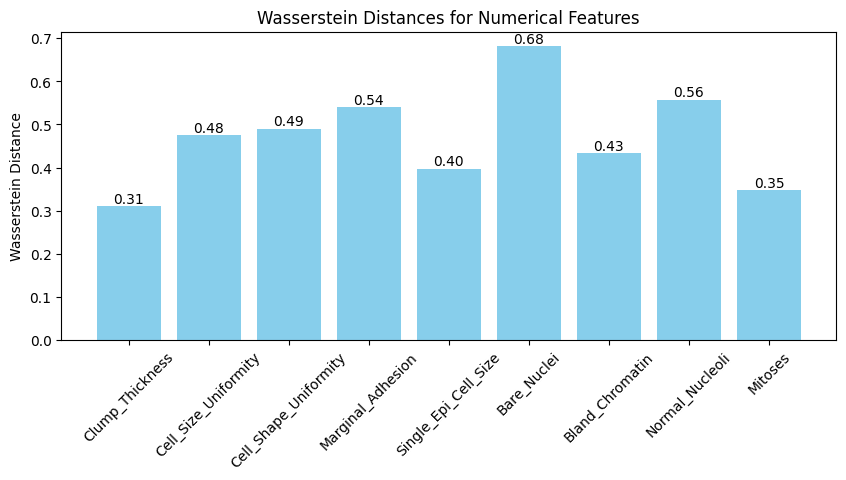

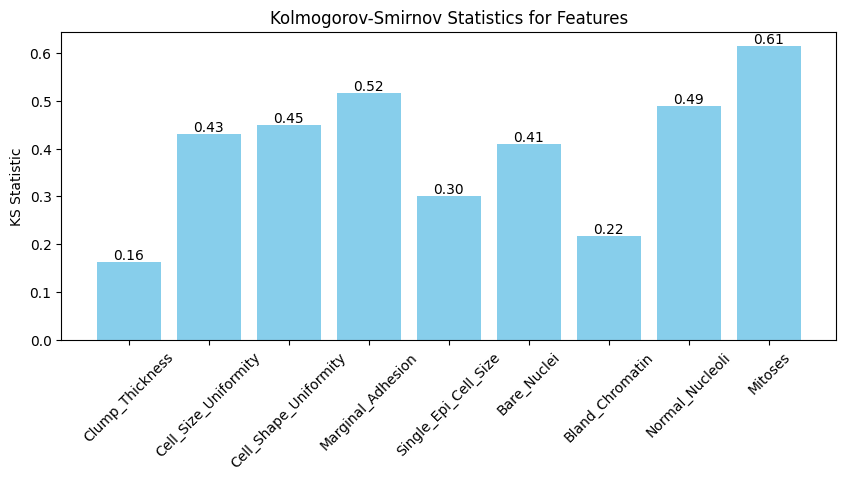

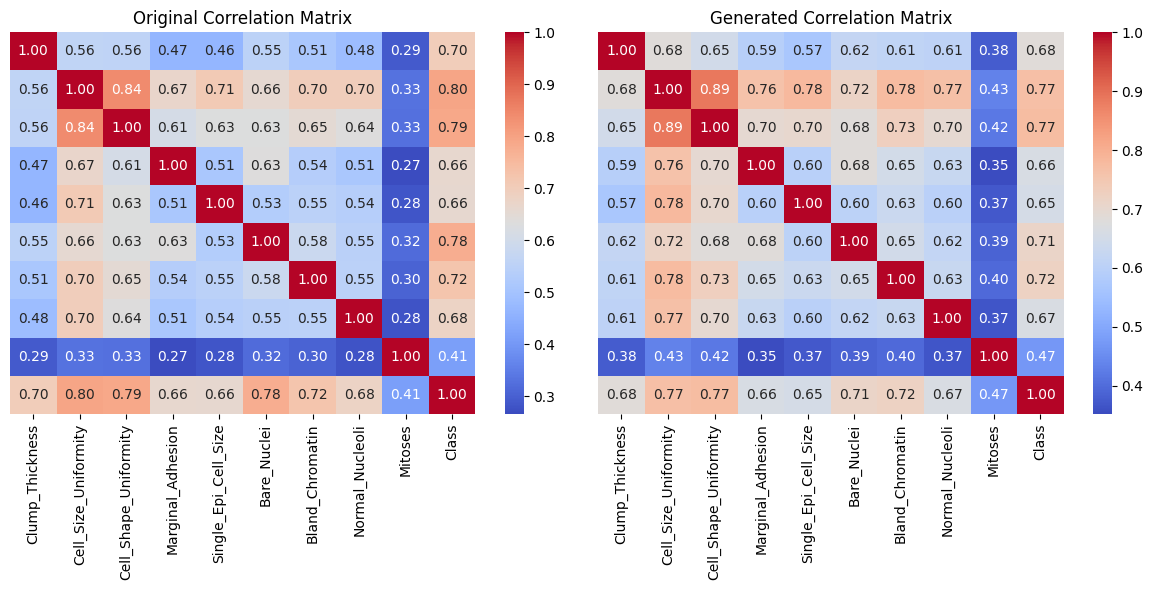

Pearson Correlation Coefficient: 0.98


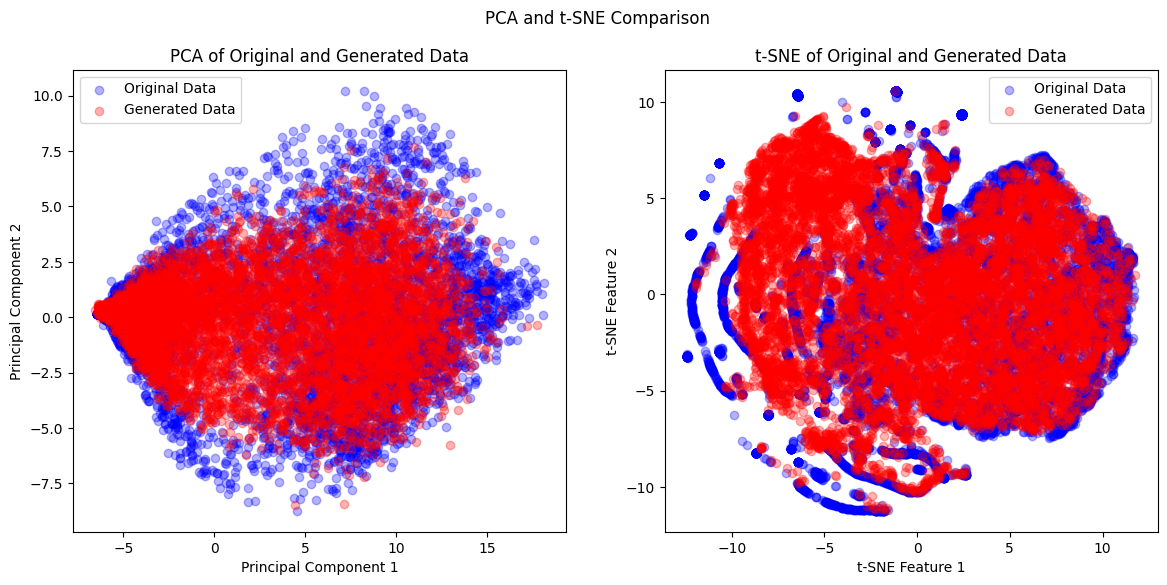

100%|██████████| 100/100 [01:01<00:00,  1.63it/s]


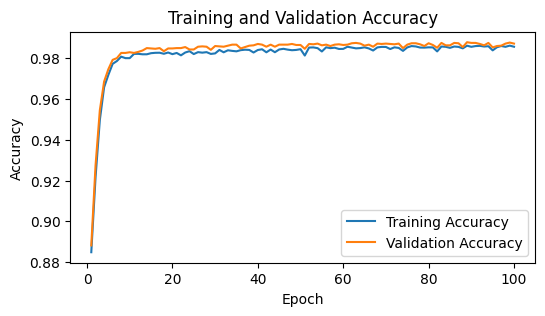

Test Accuracy: 0.9841


100%|██████████| 100/100 [01:00<00:00,  1.65it/s]


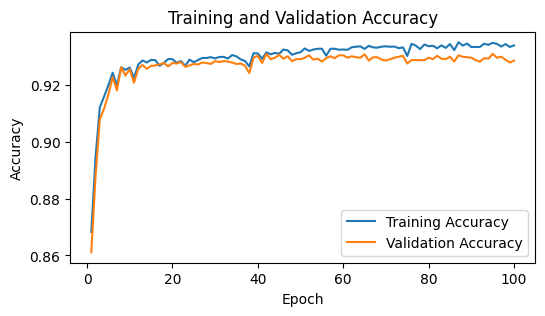

Test Accuracy: 0.9353


Classifier Trained by Original Dataset  \
Original Testing Set Accuracy                                    0.984   
Generated Testing Set Accuracy                                   0.911   

                                Classifier Trained by Generated Dataset  
Original Testing Set Accuracy                                     0.950  
Generated Testing Set Accuracy                                    0.935

In [ ]:
# Generate synthetic data and conduct analyses using the SDAT framework for a medical dataset
new_data = get_new_data(url='https://drive.google.com/file/d/1ZMnQFj8enCsGp6H_-qUMxteY6ue6Abqg/view?usp=drive_link', output_name='new_breast_cancer.csv')

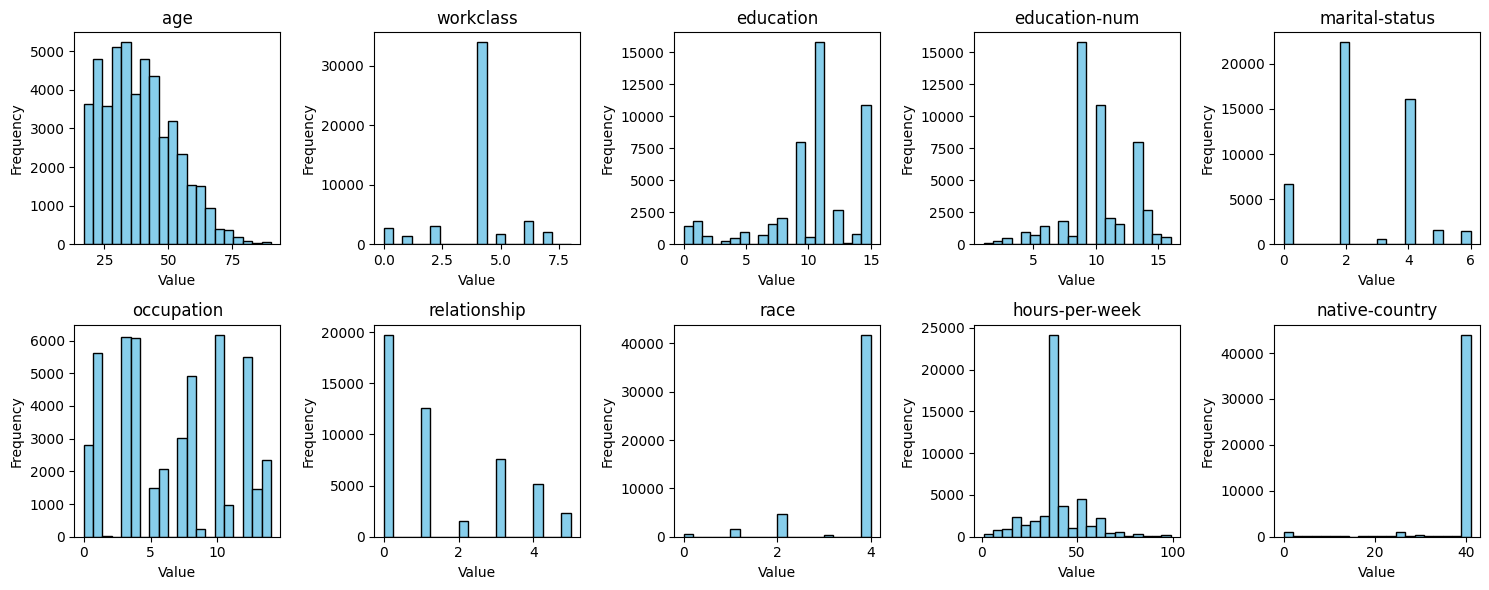

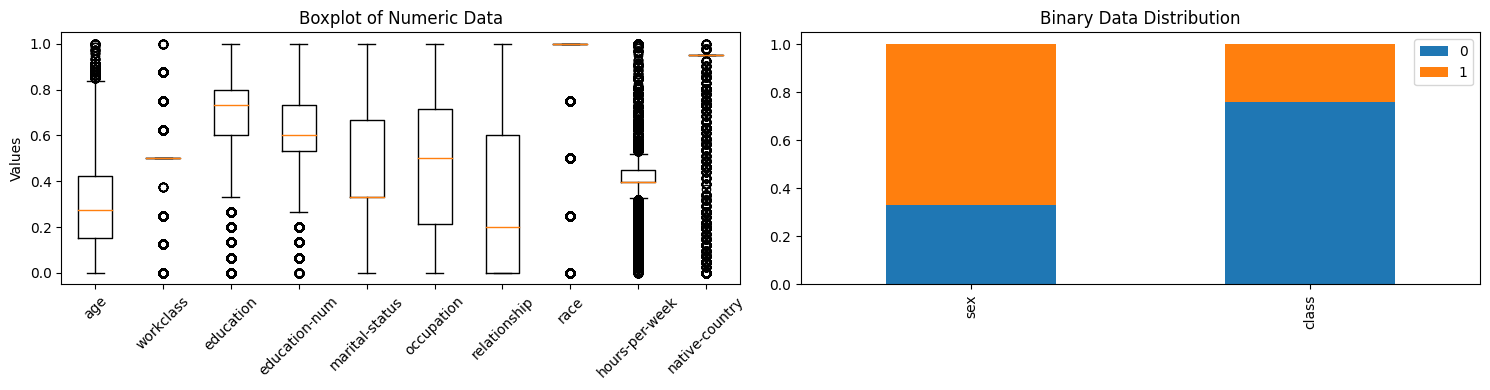

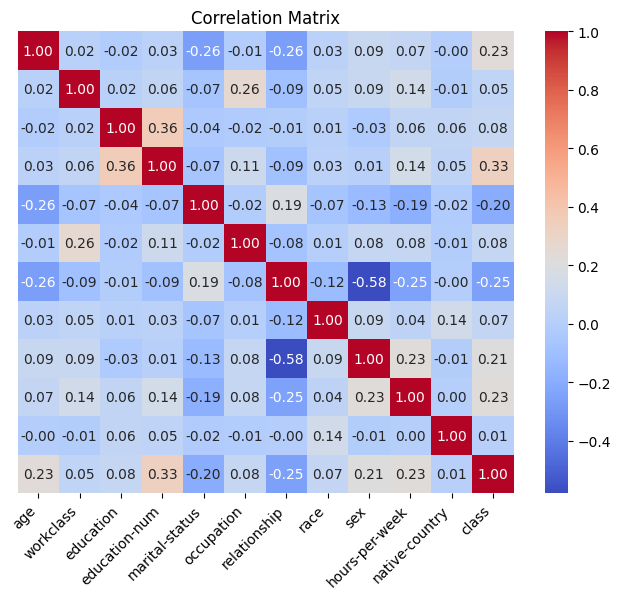

  1%|          | 1/150 [00:01<03:03,  1.23s/it]

Epoch 1/150, Average Loss: 61.602
Accuracy on valid set - original: 0.755, generated: 0.755


 21%|██        | 31/150 [00:42<02:46,  1.40s/it]

Epoch 31/150, Average Loss: 1.482
Accuracy on valid set - original: 0.755, generated: 0.755


 41%|████      | 61/150 [01:26<02:16,  1.54s/it]

Epoch 61/150, Average Loss: 1.361
Accuracy on valid set - original: 0.755, generated: 0.755


 61%|██████    | 91/150 [02:08<01:24,  1.44s/it]

Epoch 91/150, Average Loss: 1.307
Accuracy on valid set - original: 0.755, generated: 0.755


 81%|████████  | 121/150 [02:50<00:39,  1.38s/it]

Epoch 121/150, Average Loss: 1.250
Accuracy on valid set - original: 0.755, generated: 0.755


100%|██████████| 150/150 [03:31<00:00,  1.41s/it]

Epoch 150/150, Average Loss: 0.983
Accuracy on valid set - original: 1.000, generated: 0.957


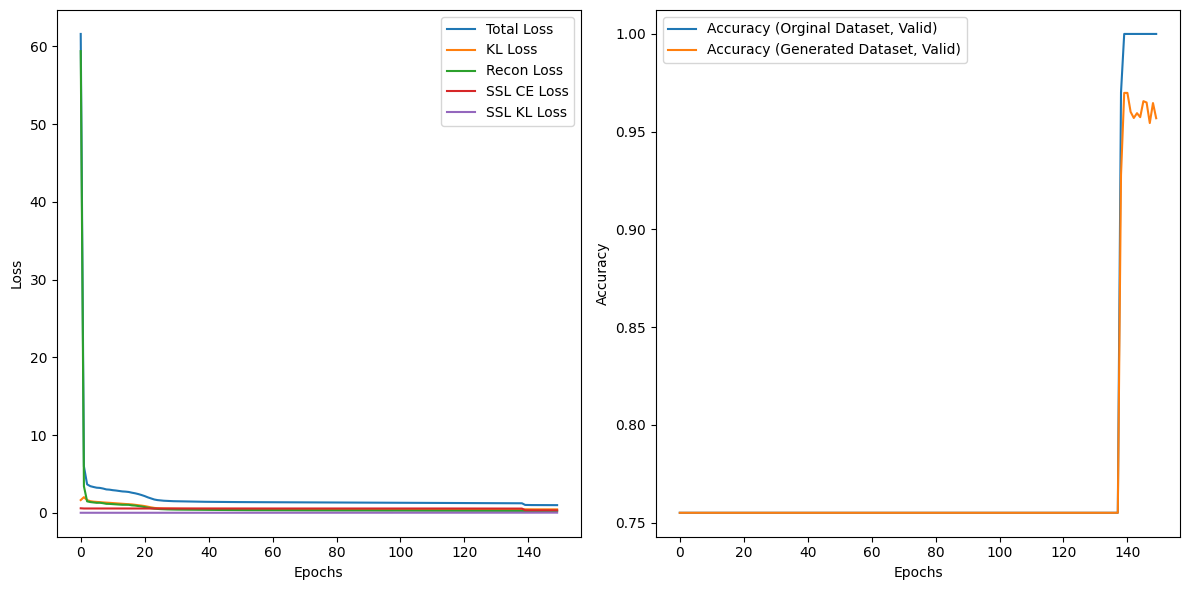

age  workclass  fnlwgt     education  education-num      marital-status  \
0   25    Private  226802          11th              7       Never-married   
1   38    Private   89814       HS-grad              9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm             12  Married-civ-spouse   
3   44    Private  160323  Some-college             10  Married-civ-spouse   
4   18          ?  103497  Some-college             10       Never-married   

          occupation relationship   race     sex  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                  ?    Own-child  White  Female             0             0   

   hours-per-week native-country  class  
0              40  United-States  <=50K  
1              50  United-States  <=50K  
2              40  United-States   >50K  
3              40  United-States   >50K  
4              30  United-States  <=50K

age         workclass     education  education-num         marital-status  \
0   44  Self-emp-not-inc       5th-6th              4      Married-AF-spouse   
1   38      Never-worked  Some-college             10     Married-civ-spouse   
2   32         Local-gov          12th              7     Married-civ-spouse   
3   37         Local-gov           9th              7  Married-spouse-absent   
4   30           Private       Masters             13     Married-civ-spouse   

          occupation    relationship   race     sex  hours-per-week  \
0     Prof-specialty   Not-in-family  White    Male              37   
1       Armed-Forces   Not-in-family  White    Male              31   
2  Handlers-cleaners         Husband  White    Male              59   
3              Sales            Wife  Other  Female              31   
4  Handlers-cleaners  Other-relative  White  Female              31   

    native-country  class  
0  Trinadad&Tobago  <=50K  
1    United-States  <=50K  
2    United-States  <=50K  
3    United-States  <=50K  
4    United-States  <=50K

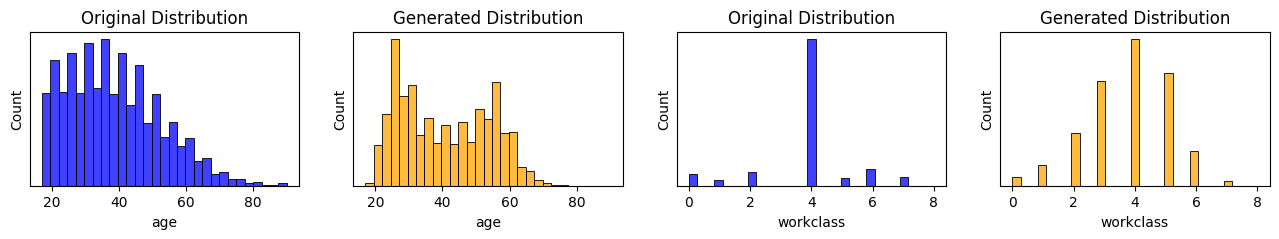

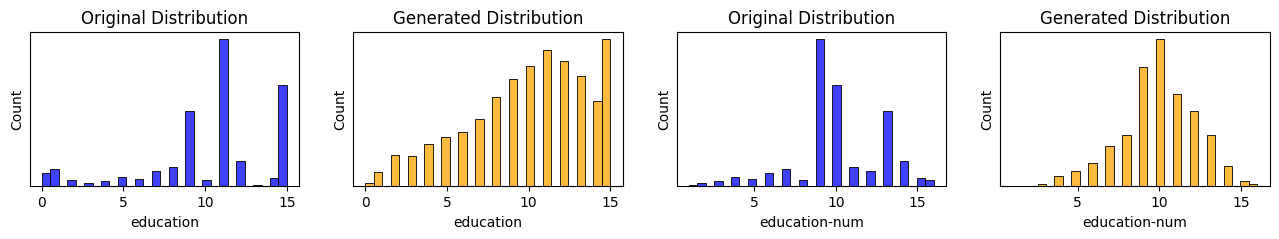

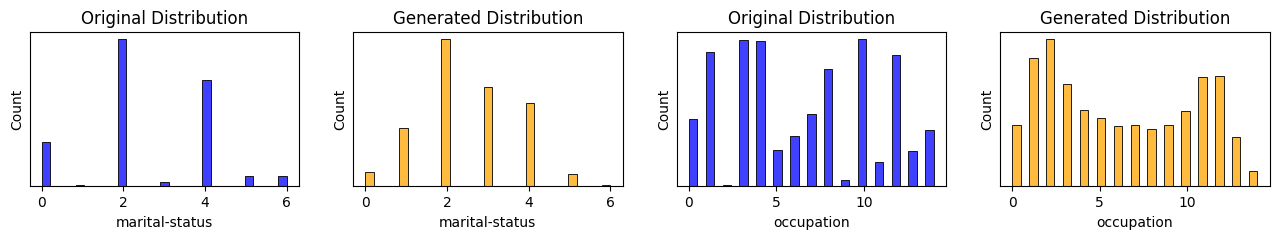

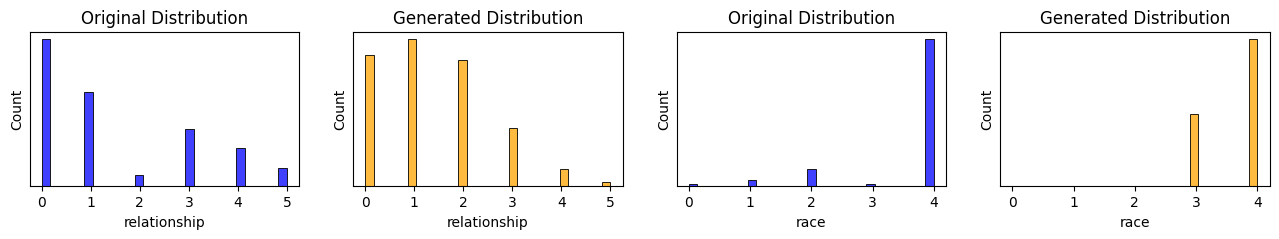

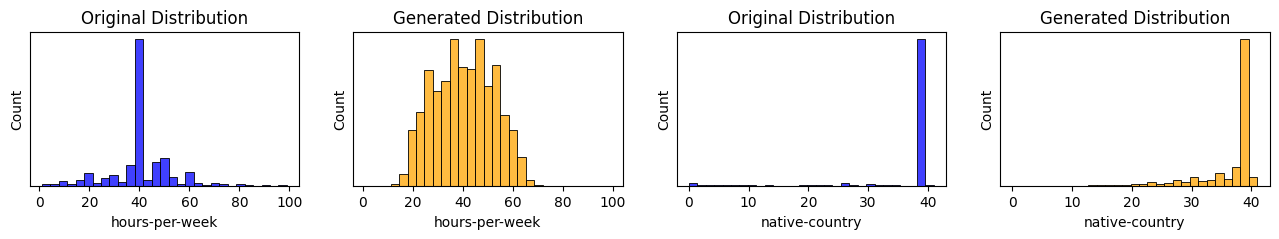

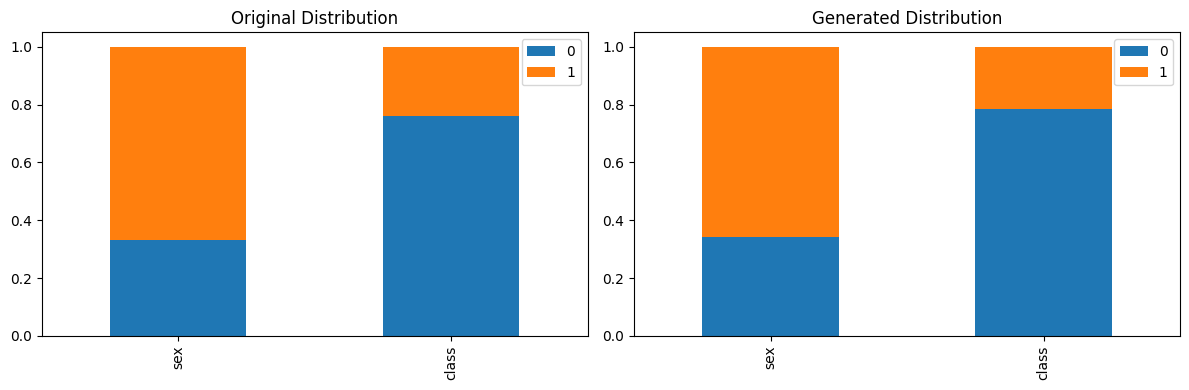

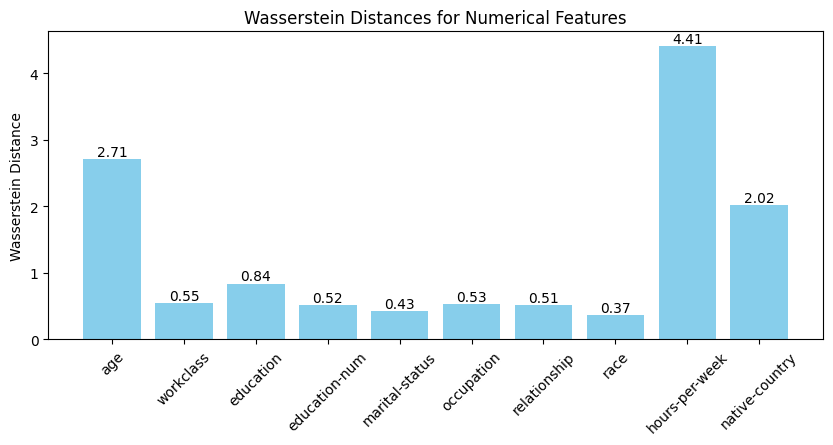

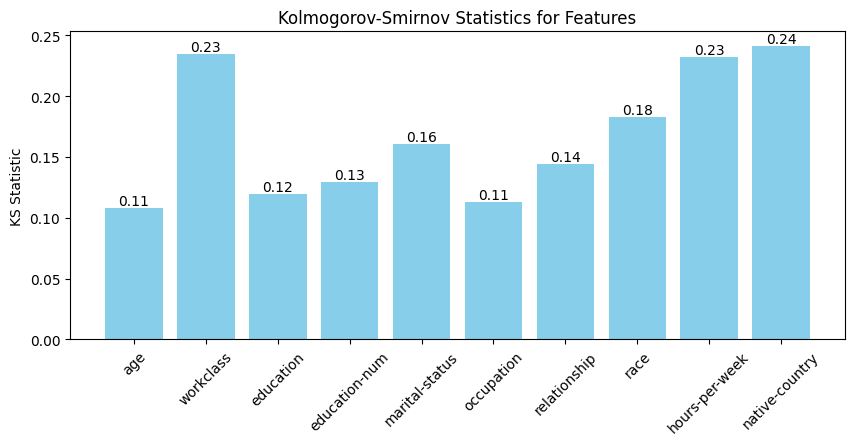

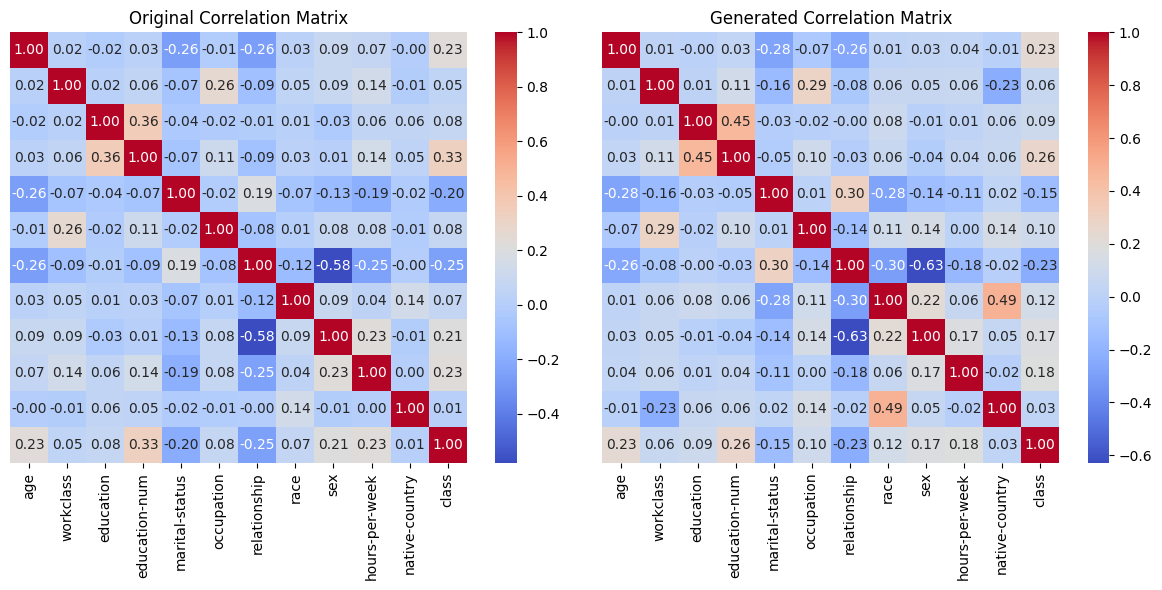

Pearson Correlation Coefficient: 0.97


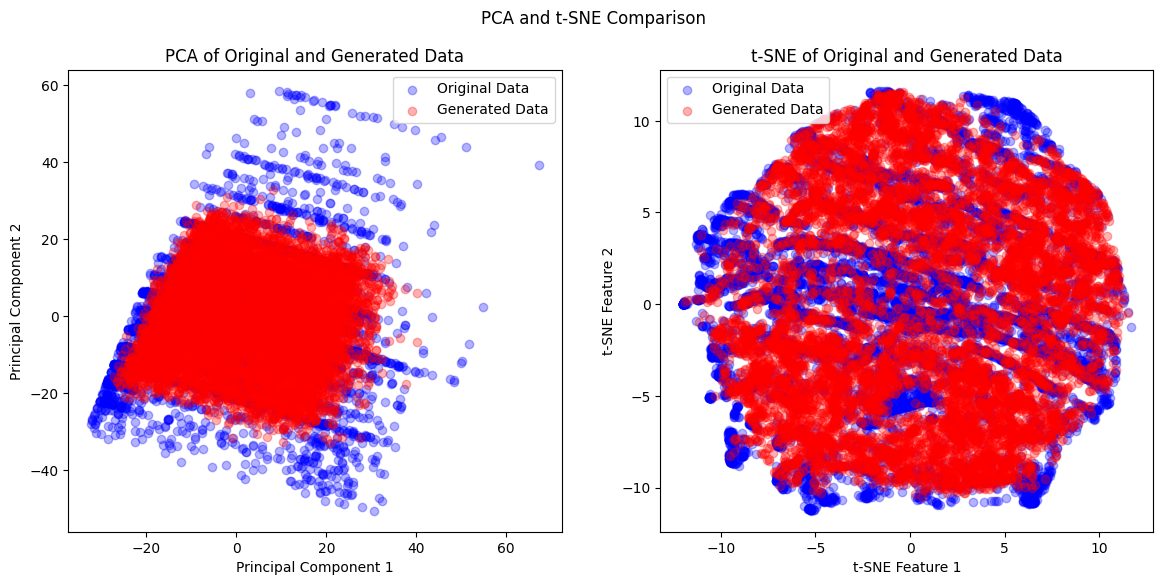

100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


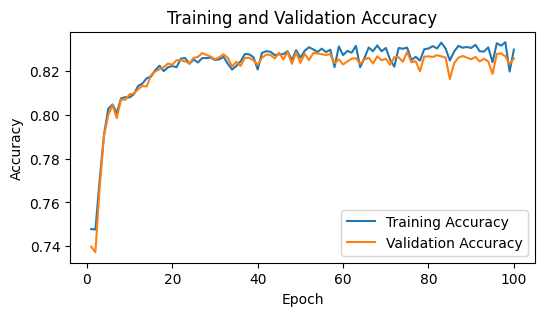

Test Accuracy: 0.8261


100%|██████████| 100/100 [01:15<00:00,  1.33it/s]


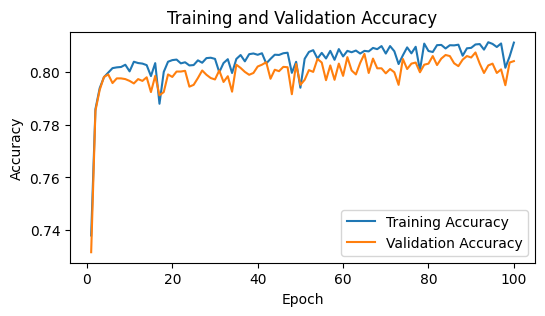

Test Accuracy: 0.8057


Classifier Trained by Original Dataset  \
Original Testing Set Accuracy                                    0.826   
Generated Testing Set Accuracy                                   0.793   

                                Classifier Trained by Generated Dataset  
Original Testing Set Accuracy                                     0.806  
Generated Testing Set Accuracy                                    0.806

In [ ]:
# Generate synthetic data and conduct analyses using the SDAT framework for a financial dataset
new_data = get_new_data(url='https://drive.google.com/file/d/1yRGB7Xo2EBQ4pOdT9ltJN0M7cvYrdVvD/view', output_name='new_income_prediction.csv', dropout=['id', 'fnlwgt','capital-gain','capital-loss'])

Using the above evaluation methods, we observe that our model is capable of generating a very similar anonymized dataset for newly obtained medical (for breast cancer prediction) and financial (for income prediction) datasets. It generally preserves the statistics of the original datasets. As mentioned in the first dataset, the data distribution seems to closely align with the original, except that it appears to build a normal distribution on each original data point. Correlation matrices show that it can capture some relationships between features, and the Pearson Correlation Coefficient still exhibits higher scores. Wasserstein and KS distances show relatively low values, while the PCA and t-SNE plots of the generated data align with the original data but occupy slightly smaller areas. Lastly, predictions from basic machine learning models show similar scores, within an acceptable range of less than a 10% difference in accuracy.

# Discussion

**Overall Result**

Based on our evaluations using the above metrics, we conclude that our model, applied to all three datasets, generated a secondary anonymized dataset with very similar quantitative characteristics.

However, from a qualitative standpoint, we believe that our model produces decent results. Through our experiments, it became apparent that maintaining **ALL** statistical properties of a dataset is challenging. It appears more practical to adjust the model, such as changing the loss function, to specifically preserve the statistical properties required for a particular downstream task. As we did not have a specific downstream task in mind, we implemented a variety of generally useful statistical measures to quantitatively evaluate our model.

***

**Difficulties**

Some dificulties that we faced during this project include:

***High-Dimensional Multi-Categorical Features (>2):*** Managing features like 'country of birth' posed challenges due to their high dimensionality. Various solutions were considered, one of which involved transforming a single multi-categorical feature into multiple binary features. For instance, in the first dataset, the 'age' feature with categories [under 20, between 20 and 40, over 60] was converted into three binary features: 'under 20,' 'between 20 and 40,' and 'over 60.' While this approach significantly increased the number of features, it performed roughly well experimentally in terms of quantitative measures and machine learning models. However, a limitation arose as it couldn't ensure that each individual data point had only one of these three features ('under 20,' 'between 20 and 40,' and 'over 60'). This constraint rendered the method unsuitable if the feasibility of individual data points was crucial for the downstream task. Therefore, the specific model architecture and design should be tailored to the particular downstream task.

Another potential solution involved treating this as a multiple classification task, where the loss would be changed to cross-entropy instead of BCE or MSE. The objective here would be to maximize the likelihood that the model assigns the same class as the input data. However, this method could be considered complex, particularly when incorporating it into the network, as each feature may have a different number of categories. Consequently, separate probability predictions and losses would be needed before later combining them.

***Feature with a wider numerical range***: Dealing with features that have a larger numerical range than others can be problematic as they may either dominate other features or lead to an exploding gradient. This issue is more pronounced in the third dataset, where some features have a range exceeding 10K, necessitating preprocessing for elimination. However, simply dropping columns may not be the ideal solution. Various ideas were considered, including normalizing the data during preprocessing. However, this approach resulted in a narrower range in the distribution of generated data.

To address this, we implemented batch normalization in the encoder and introduced gradient clipping to enhance stability during training. While these measures improved stability and can handle values up to a hundred, dealing with higher values, such as more than ten-thousand, remains inefficient.


***

**Comparisons**

One of the things we learned was that our version of the SDAT architecture performed much better (experimentally) than the basic VAE architecture we tried in the initial stages of this project. While the VAE architecture was capable of replicating the distributions of each individual feature quite well, it struggled to replicate the inter-feature correlations.

Furthermore, when compared to the original SDAT model proposed in [2], our model demonstrated superior performance in terms of statistical relationships within the data. Two main modifications that we made include using different types of loss for various data types (e.g., BCE for binary data instead of MSE for all types), resulting in a more similar distribution in binary features. Another modification is related to the input data for the encoder; we changed it from excluding labels to including labels, thereby increasing the correlations between labels and other features, as is evident in the correlation matrix.

#  Conclusion

This concludes the final report of our project **Leveraging Synthetic Data for Enhanced Data Protection**. Our google colab is available here: https://drive.google.com/file/d/1I7UJxNT0hxkZtidL2TCAjZNv4OOXfvXg/view?usp=sharing



---

